## Import Libs

In [64]:
import os
from os import listdir
from collections import Counter
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import tensorflow as tf
import missingno as msno
import math
from tqdm import tqdm


from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, auc, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from plot_metric.functions import BinaryClassification

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from keras.models import clone_model

from keras.utils.vis_utils import plot_model
# import visualkeras

In [2]:
# check the system font
import matplotlib.font_manager as font_manager
font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

# add the font wanted
font_dir = ['../EarlySepsisPrediction/Latin-Modern-Roman']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'Latin Modern Roman'
print(plt.rcParams['font.family'])

['Latin Modern Roman']


Fontconfig warning: ignoring UTF-8: not a valid region tag


## Load Data

### Data Process Function

In [25]:
def process_data_engineered(patient_ids, patients_path, data_features):
    # prepare data
    X_train = []
    y_train = []
    # total_X_data = []

    for i in tqdm(patient_ids):
        i = str(np.char.replace(i,'psv','csv'))
        # drop un-related data
        data = pd.read_csv(patients_path+i,sep = ',')
        data.drop(['subject_id'], axis = 1,inplace = True)
        if 'time' in data.columns: 
            data.drop(['time'], axis = 1,inplace = True)
        
        data = data.replace([True, False],[1,0])
        
        # to label whether this patient has sepsis or not,
        # leave only one label for one .psv file (patient)
        label_sepsis = data['sepsis'].sum()
        if label_sepsis:
            y_train.append(1)
        else:
            y_train.append(0)
        data.drop(['sepsis'],axis = 1,inplace = True)
        
        # this empty row need to be changed for engineered data
        empty_row = {'HR':0, 'SaO2':0, 'Temp':0, 'SBP':0, 'MAP':0, 'DBP':0, 'RR':0, 'BaseExcess':0, 'HCO3':0,
                    'PH':0, 'BUN':0, 'Calcium':0, 'Chloride':0, 'Creatinine':0, 'Glucose':0, 'Lactic':0,
                    'Magnesium':0, 'Potassium':0, 'PTT':0, 'WBC':0, 'Platelet':0, 'age':data['age'][0], 'gender':data['gender'][0],
                    'HR_dev_1':0, 'HR_dev_2':0, 'HR_dev_3':0, 'RR_dev_1':0, 'RR_dev_2':0, 'RR_dev_3':0, 'Temp_dev_1':0, 'Temp_dev_2':0, 'Temp_dev_3':0,
                    'Bradycardia':0, 'Tachycardia':0, 'Hypothermia':0, 'Fever':0, 'Hyperpyrexia':0}

        # unify the length of the input data
        if len(data) < 40:
            Pad = pd.DataFrame(empty_row, index =[item for item in range(0,40-len(data))])
            data = pd.concat([Pad, data]).reset_index(drop = True)
            # data = data.reindex(range(40),fill_value = 0) # use this line to padd zeros at the data end
        elif len(data) > 40:
            data = data[len(data)-40::1]
        data = data.reset_index(drop = True)

        data = data[data_features] # re-arrange the order of features before converting to array

        # total_X_data = pd.concat([total_X_data, data]).reset_index(drop = True)

        data = data.values.astype(np.float64) # from DataFrame to numpy array
        X_train.append(data)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train

In [18]:
artificial_neonatal_data_path = '../artificial_neonatal_data/data/balanced_2000/engineered_all/'
all_artificial_neonates = np.load('../artificial_neonatal_data/data/balanced_2000/test_set.npy')

## Visualze model structure

In [ ]:
# !pip install visualkeras
# !brew install graphviz
# !mkdir ./figs

In [3]:
optimized_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
optimized_model.build(input_shape=(None,40,15))
plot_model(optimized_model, to_file='./figs/model_plot.pdf', show_shapes=True, show_layer_names=True)

## Re-train model

In [39]:
!mkdir -p ./trained_models/frozen4
!mkdir -p ./trained_models/frozen3
!mkdir -p ./trained_models/frozen2
!mkdir -p ./trained_models/frozen1

In [47]:
!mkdir -p ./figs/frozen4
!mkdir -p ./figs/frozen3
!mkdir -p ./figs/frozen2
!mkdir -p ./figs/frozen1

### Frozen 4 LSTMs

In [65]:
# case 1: frozen all LSTM
base_model_f4 = tf.keras.models.load_model('../models_adults/model_LSTM/trained_models/EDWFS/model_5.h5')
for i, layer in enumerate(base_model_f4.layers):
    layer._name = 'layer_' + str(i)
base_model_f4.layers[0].trainable = False
base_model_f4.layers[2].trainable = False
base_model_f4.layers[4].trainable = False
base_model_f4.layers[6].trainable = False
base_model_f4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_0 (LSTM)              (None, 40, 128)           76288     
                                                                 
 layer_1 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_2 (LSTM)              (None, 40, 128)           131584    
                                                                 
 layer_3 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_4 (LSTM)              (None, 40, 128)           131584    
                                                                 
 layer_5 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_6 (LSTM)              (None, 128)              

100%|██████████| 2000/2000 [00:15<00:00, 130.09it/s]


------Fold 1------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.6931WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbe380754d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_

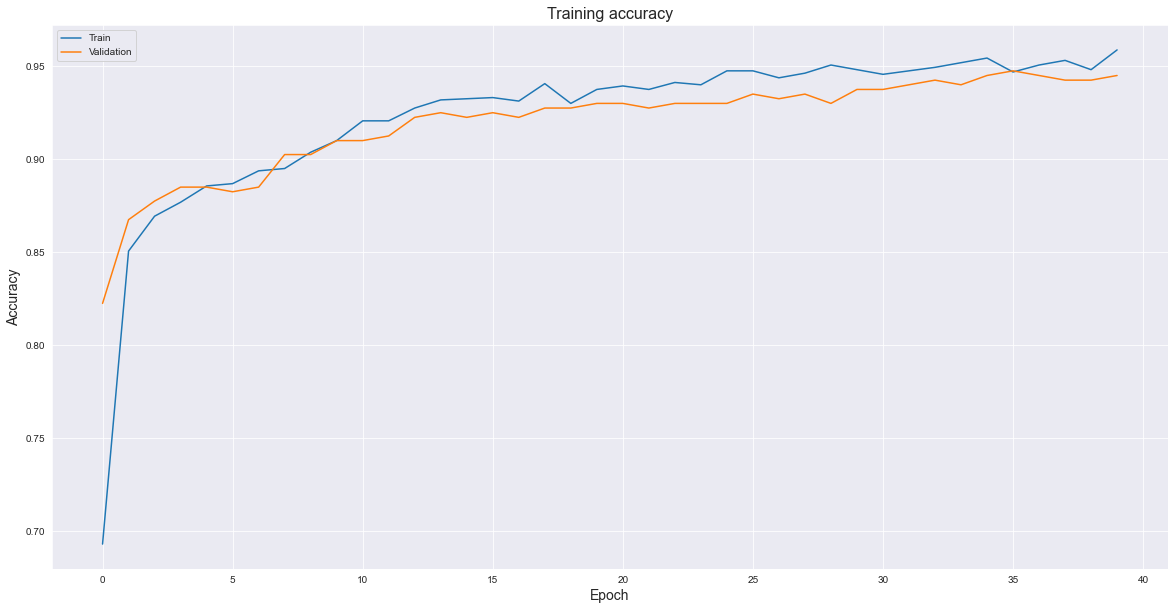

<Figure size 432x288 with 0 Axes>

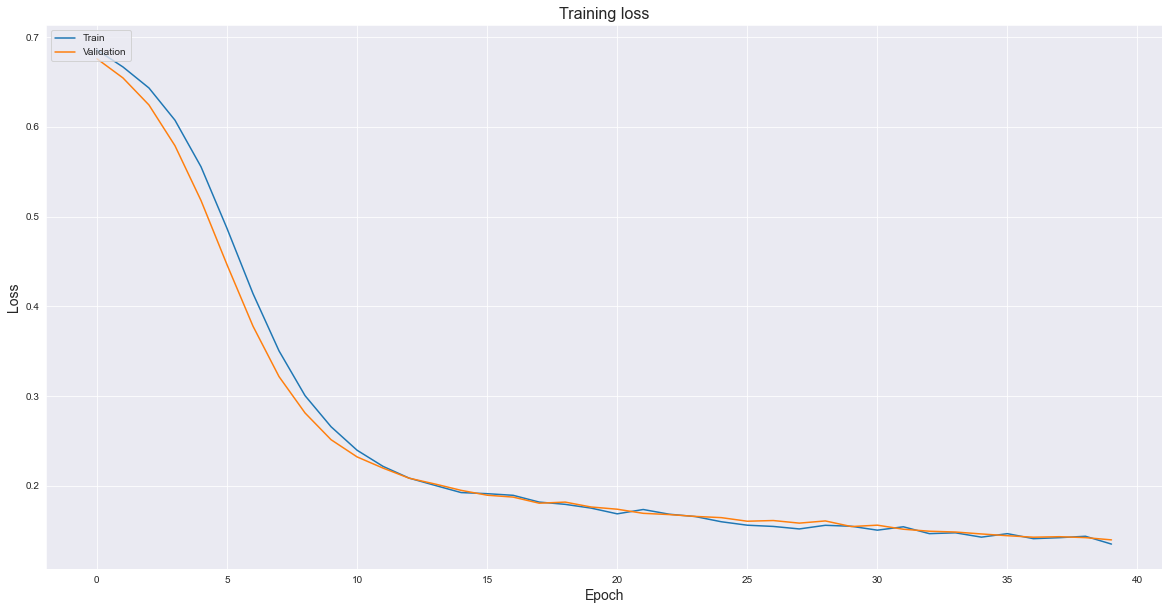

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9861973601508485
validation dataset AUPRC: 0.9797201856029961
validation dataset acc: 0.945
validation dataset F1: 0.9424083769633509
------Fold 2------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

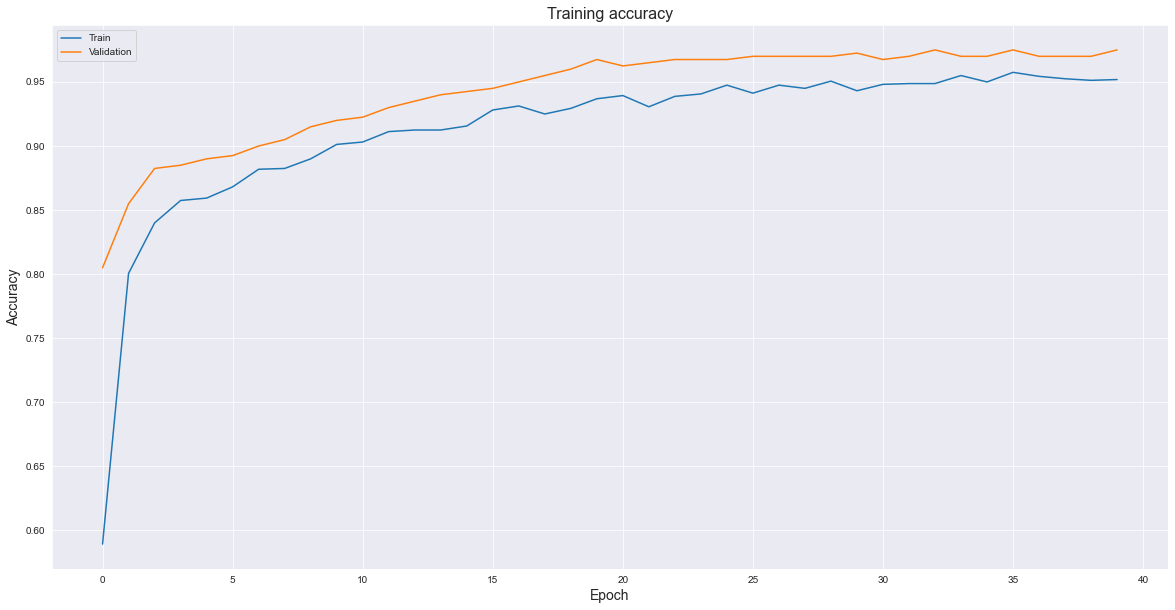

<Figure size 432x288 with 0 Axes>

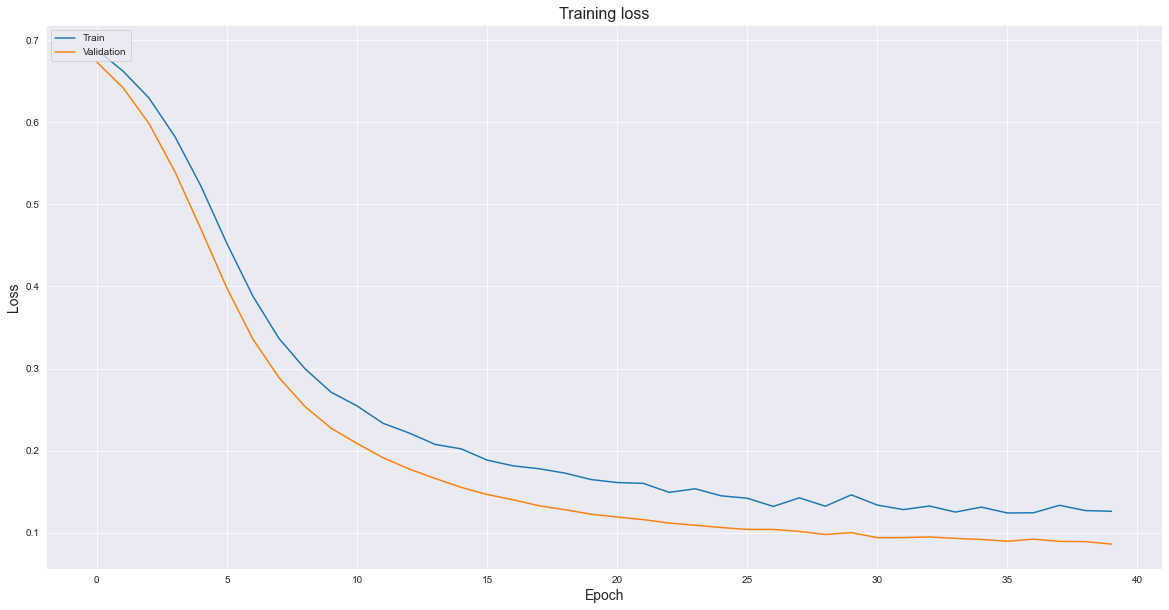

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9934208880550344
validation dataset AUPRC: 0.9924861305921082
validation dataset acc: 0.975
validation dataset F1: 0.9757281553398058
------Fold 3------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

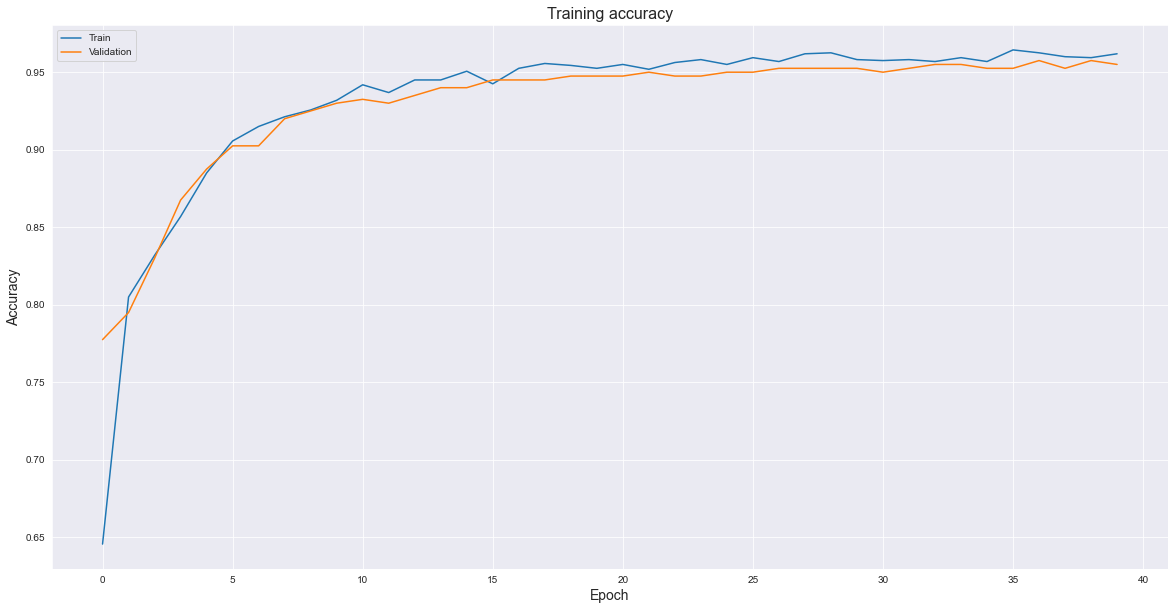

<Figure size 432x288 with 0 Axes>

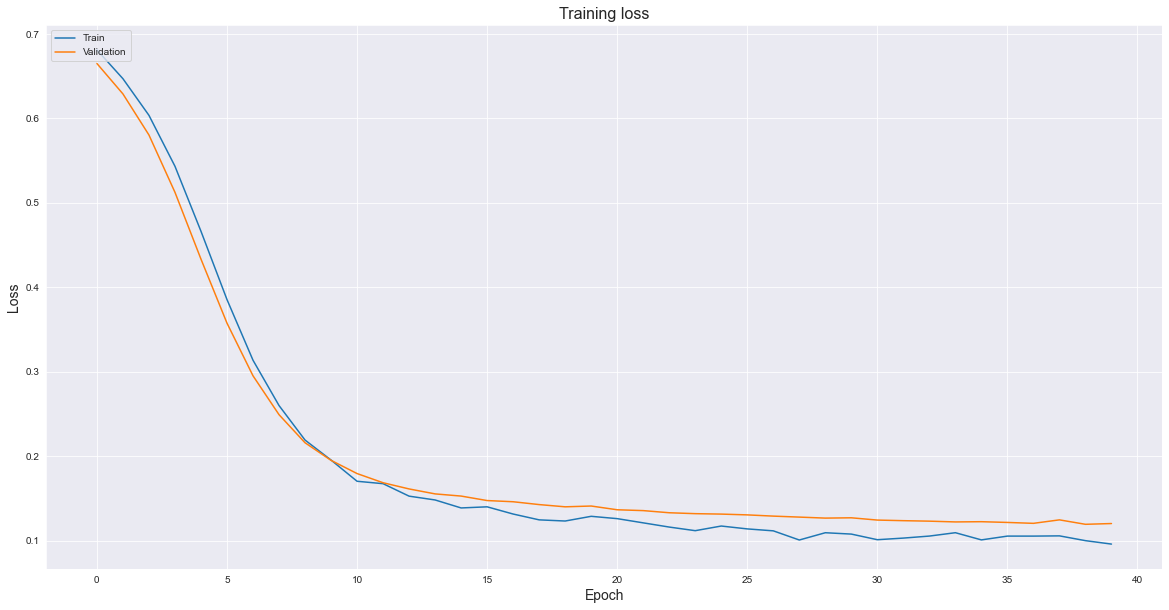

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9889180737961226
validation dataset AUPRC: 0.9878290132527459
validation dataset acc: 0.955
validation dataset F1: 0.9571428571428571
------Fold 4------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

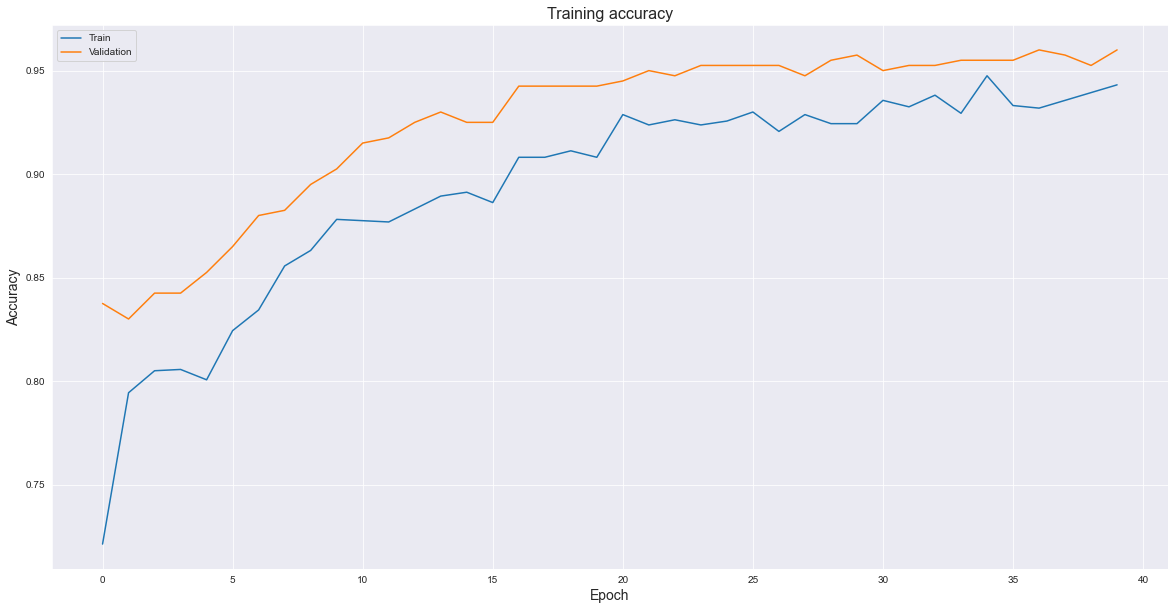

<Figure size 432x288 with 0 Axes>

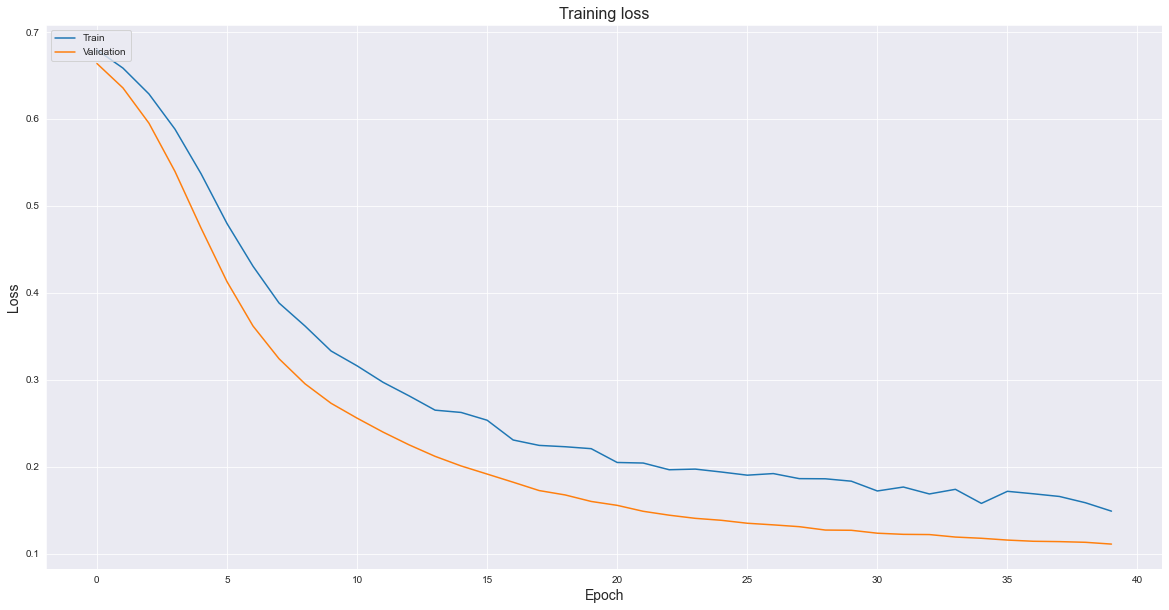

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9944215134459037
validation dataset AUPRC: 0.9944210200524669
validation dataset acc: 0.96
validation dataset F1: 0.9597989949748744
------Fold 5------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

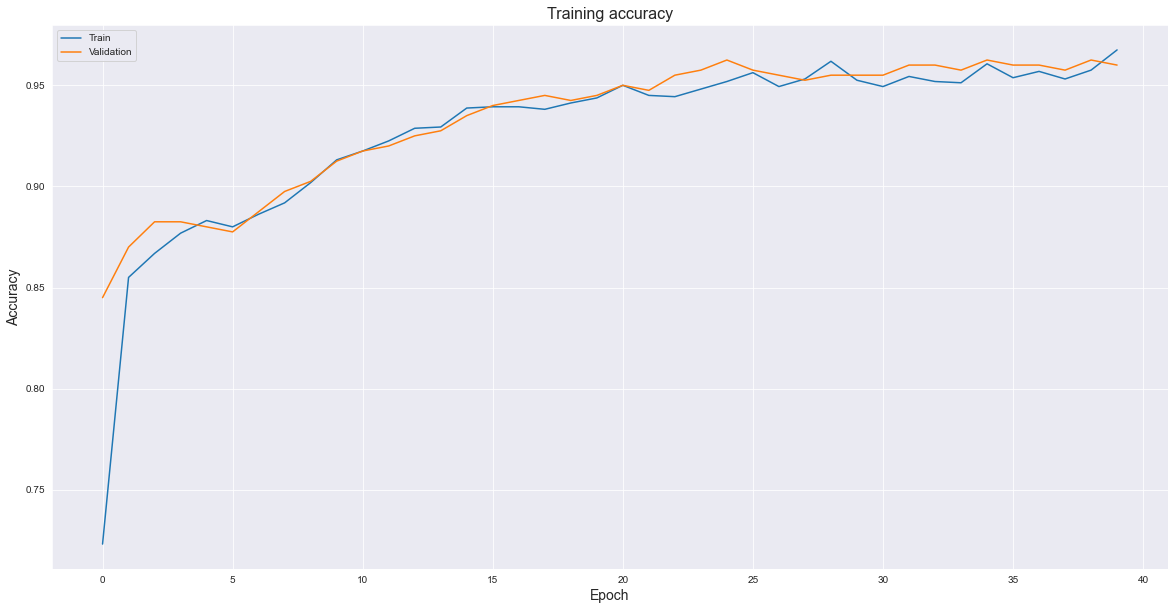

<Figure size 432x288 with 0 Axes>

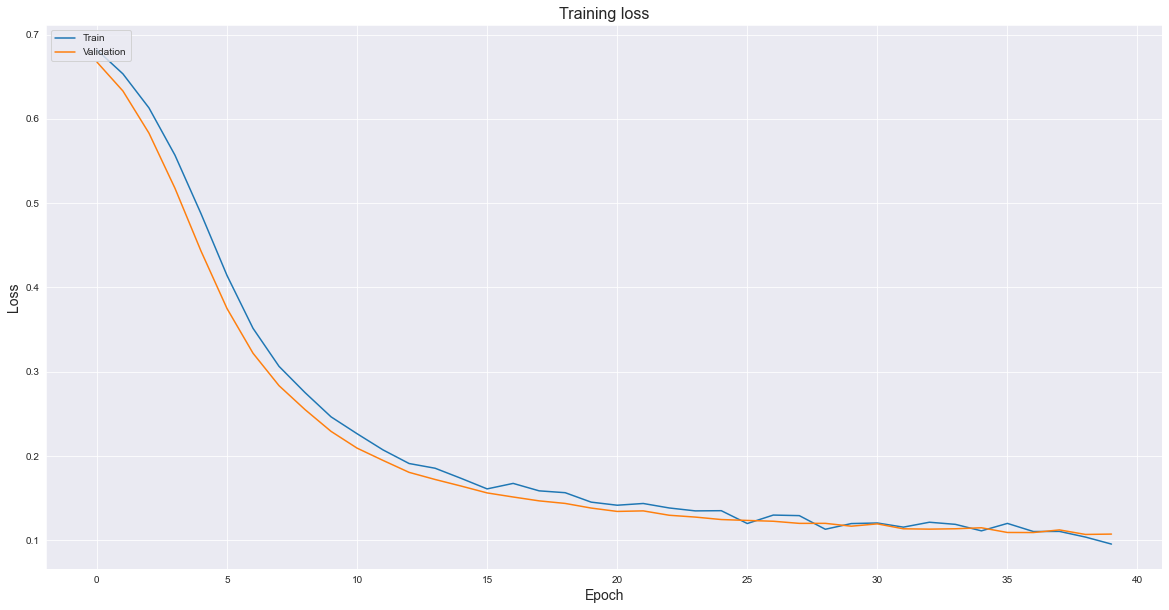

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.991578947368421
validation dataset AUPRC: 0.9910977774199757
validation dataset acc: 0.96
validation dataset F1: 0.962962962962963
Averaged validation results:
 F1_score:0.9596082694767702
 Accuracy:0.959
 AUROC:0.990907356563266
 AUPRC:0.9891108253840585



<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [67]:
# load training data
X_feature_engineered_fs = ['HR', 'SaO2', 'Temp', 'SBP', 'MAP', 
                        'DBP', 'RR', 'HCO3', 'PH', 'BUN', 
                        'Calcium', 'Chloride', 'Glucose','Potassium', 'PTT', 
                        'WBC', 'Platelet', 'age', 'HR_dev_2', 'Fever']
y_feature = ['sepsis']
X_train_, y_train_ = process_data_engineered(all_artificial_neonates,artificial_neonatal_data_path, X_feature_engineered_fs)

# lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 5-fold cross validation for tarining model
f1_list = []
accuracy_list = []
auprc_list = []
auroc_list = []
kf =KFold(n_splits=5, shuffle=True, random_state=1221)
for k, (train_index, val_index) in enumerate(kf.split(X_train_, y_train_)):
    test_preds = []
    base_model = clone_model(base_model_f4)
    base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
    print('------Fold {}------'.format(k+1))
    X_train = X_train_[train_index]
    y_train = y_train_[train_index]

    X_val = X_train_[val_index]
    y_val = y_train_[val_index]

    history = base_model.fit(X_train, y_train, epochs=40, batch_size=64, verbose=1, validation_data=(X_val, y_val), shuffle=True)
    base_model.save('./trained_models/frozen4/model_{}.h5'.format(k+1))

    # training accuracy and loss
        # acc
    plt.figure(figsize=(20,10))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training accuracy', size=16)
    plt.ylabel('Accuracy', size=14)
    plt.xlabel('Epoch', size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/frozen4/training_acc_{}.pdf'.format(k+1))
    plt.show()
    plt.clf()
        # loss 
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training loss',size=16)
    plt.ylabel('Loss',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/frozen4/training_loss_{}.pdf'.format(k+1))
    plt.show()
    plt.clf()

    # validation results
    print(' Predicting on validation data...')
    test_preds.append(base_model.predict(X_val,verbose=0).squeeze().reshape(-1, 1).squeeze())
    val_pred_proba = base_model.predict(X_val, verbose=0).squeeze()
    val_pred_class = [0 if i <= 0.5 else 1 for i in val_pred_proba]

    valid_auc = roc_auc_score(y_val, val_pred_proba)
    print('validation dataset AUROC: ' + str(valid_auc))
    precision_, recall_, thresholds_ = precision_recall_curve(y_val, val_pred_proba)
    valid_auprc = auc(recall_, precision_)
    print('validation dataset AUPRC: ' + str(valid_auprc))
    valid_acc = accuracy_score(y_val, val_pred_class)
    print('validation dataset acc: ' + str(valid_acc))
    valid_f1 = f1_score(y_val,val_pred_class)
    print('validation dataset F1: ' + str(valid_f1))
    fpr_, tpr_, thresholds_ = roc_curve(y_val, val_pred_proba)
    accuracy_list.append(valid_acc)
    f1_list.append(valid_f1)
    auroc_list.append(valid_auc)
    auprc_list.append(valid_auprc)

    # 5. plot ROC, PRc and confusion matrix
    bc = BinaryClassification(y_val,val_pred_proba, labels=['Non-sepsis', 'Sepsis'])
    plt.figure(figsize=(20,20))
    plt.subplot2grid(shape=(2,4), loc=(0,0), colspan=2)
    bc.plot_roc_curve()
    plt.subplot2grid((2,4), (0,2), colspan=2)
    bc.plot_precision_recall_curve()
    plt.subplot2grid((2,4), (1,0), colspan=2)
    bc.plot_confusion_matrix()
    plt.subplot2grid((2,4), (1,2), colspan=2)
    bc.plot_confusion_matrix(normalize=True)
    plt.savefig('./figs/frozen4/val_results_{}.pdf'.format(k+1))
    plt.clf()


def Average(lst):
    return sum(lst) / len(lst)

print('Averaged validation results:\n F1_score:{}\n Accuracy:{}\n AUROC:{}\n AUPRC:{}\n'.format(Average(f1_list),Average(accuracy_list), Average(auroc_list), Average(auprc_list)))

Averaged validation results:
* F1_score:0.9596082694767702
* Accuracy:0.959
* AUROC:0.990907356563266
* AUPRC:0.9891108253840585

### Frozen 3 LSTMs

In [68]:
# case 2: frozen first 3 LSTM
base_model_f3 = tf.keras.models.load_model('../models_adults/model_LSTM/trained_models/EDWFS/model_5.h5')
for i, layer in enumerate(base_model_f3.layers):
    layer._name = 'layer_' + str(i)
base_model_f3.layers[0].trainable = False
base_model_f3.layers[2].trainable = False
base_model_f3.layers[4].trainable = False
base_model_f3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_0 (LSTM)              (None, 40, 128)           76288     
                                                                 
 layer_1 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_2 (LSTM)              (None, 40, 128)           131584    
                                                                 
 layer_3 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_4 (LSTM)              (None, 40, 128)           131584    
                                                                 
 layer_5 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_6 (LSTM)              (None, 128)              

100%|██████████| 2000/2000 [00:14<00:00, 136.02it/s]


------Fold 1------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.6406WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbe63326b00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_

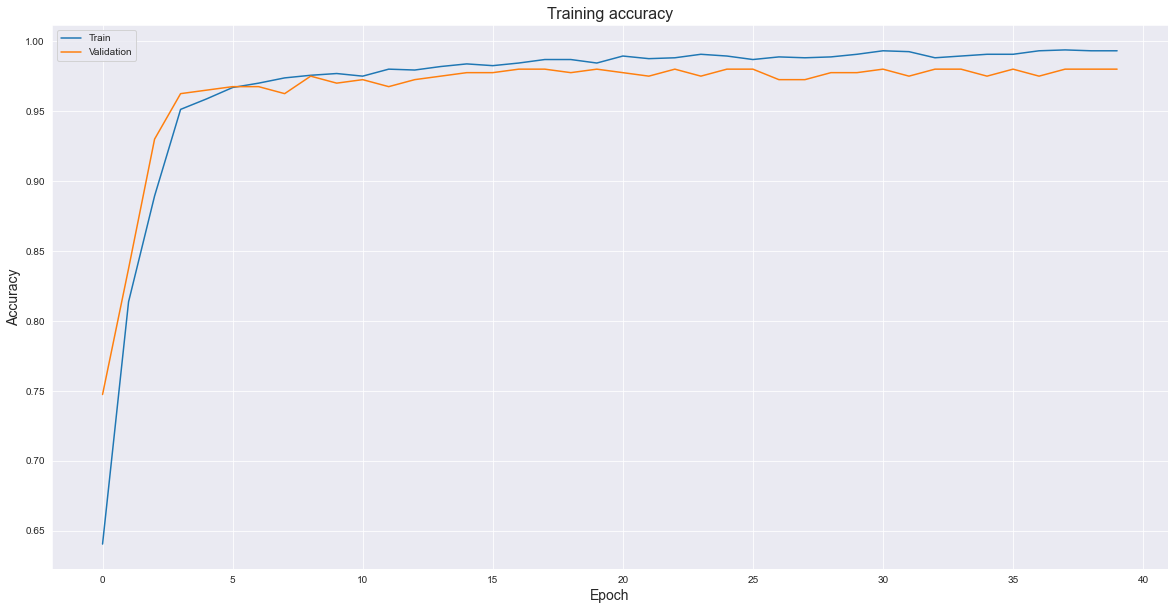

<Figure size 432x288 with 0 Axes>

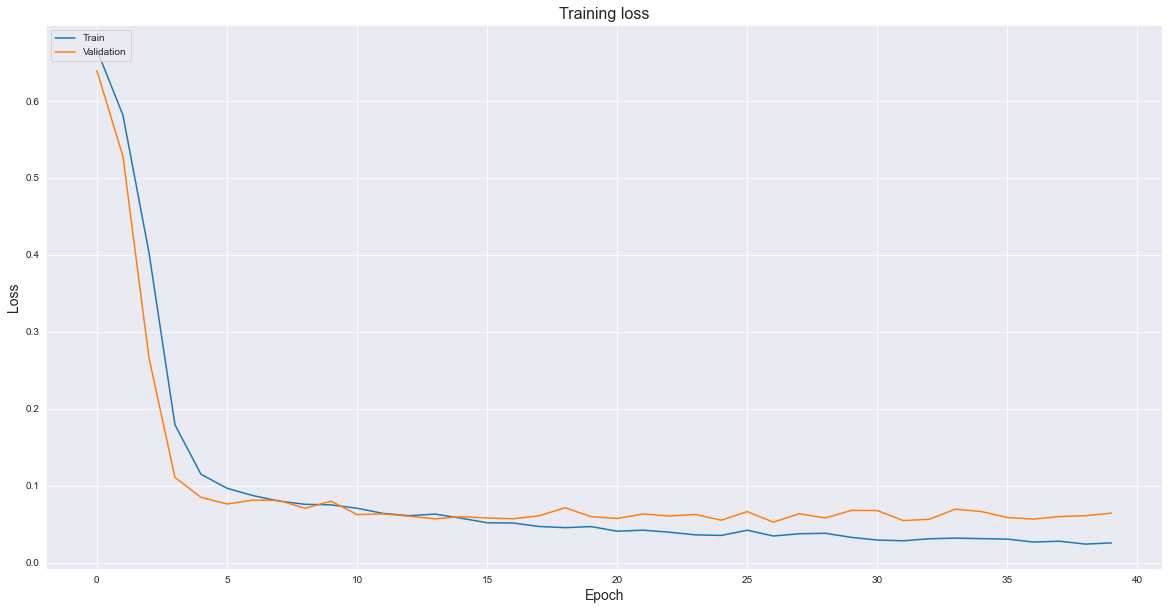

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9961533626649905
validation dataset AUPRC: 0.9938543099292273
validation dataset acc: 0.98
validation dataset F1: 0.978494623655914
------Fold 2------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

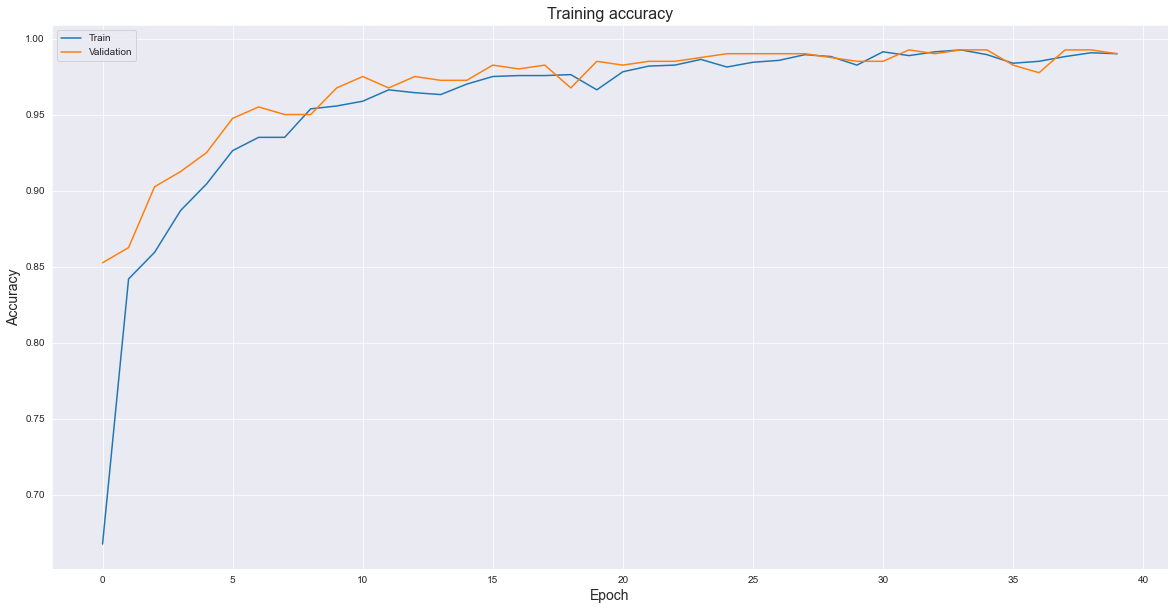

<Figure size 432x288 with 0 Axes>

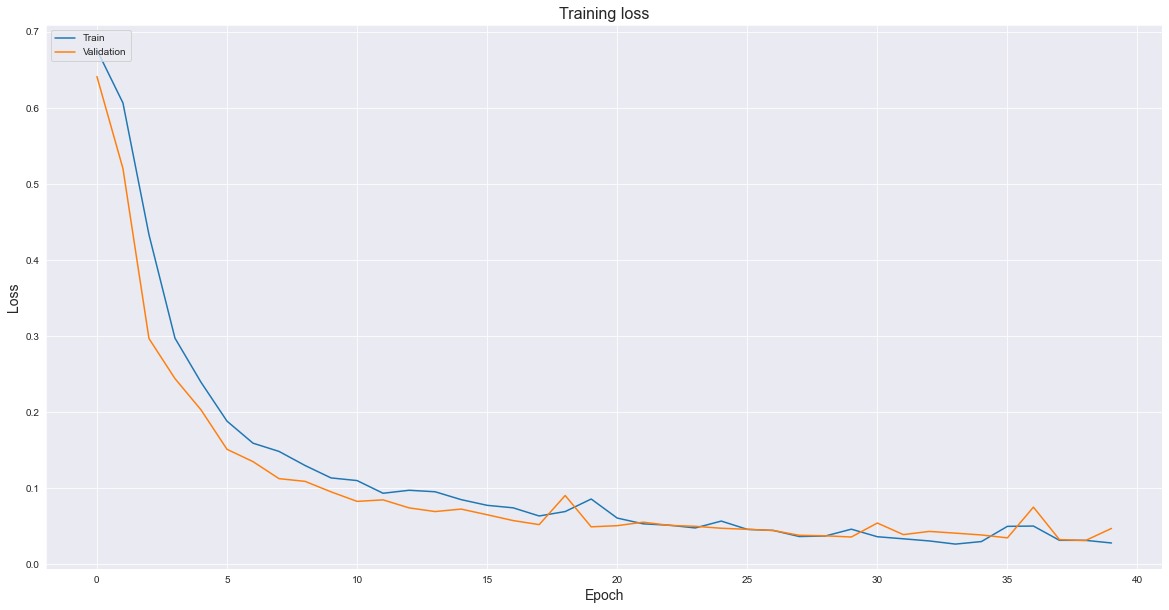

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9980988117573484
validation dataset AUPRC: 0.998018605267838
validation dataset acc: 0.99
validation dataset F1: 0.9903381642512078
------Fold 3------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

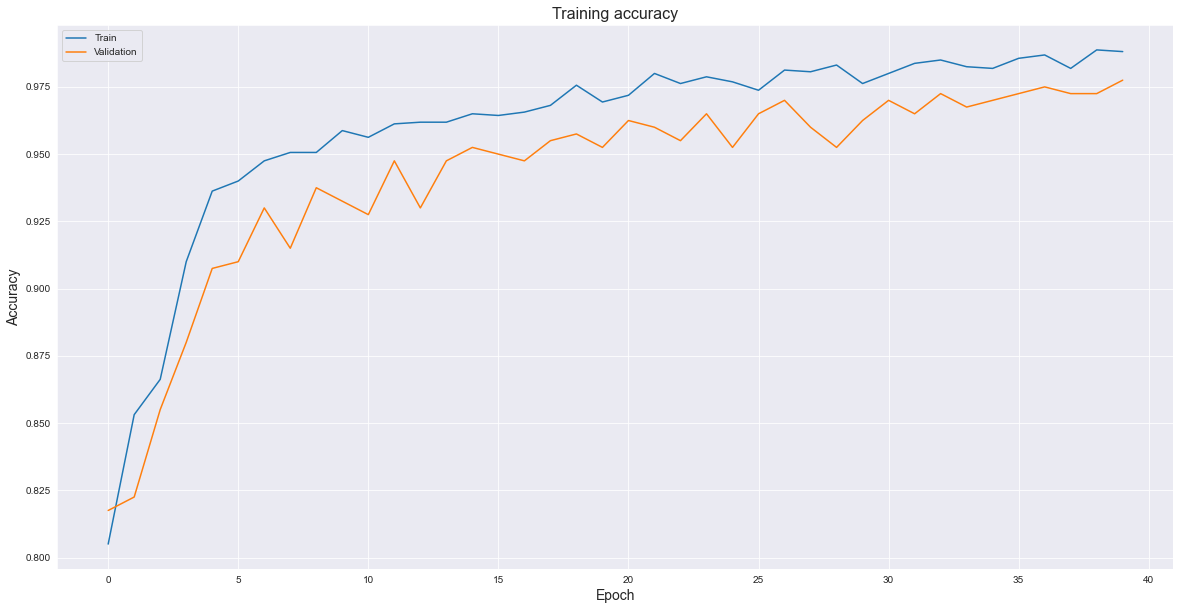

<Figure size 432x288 with 0 Axes>

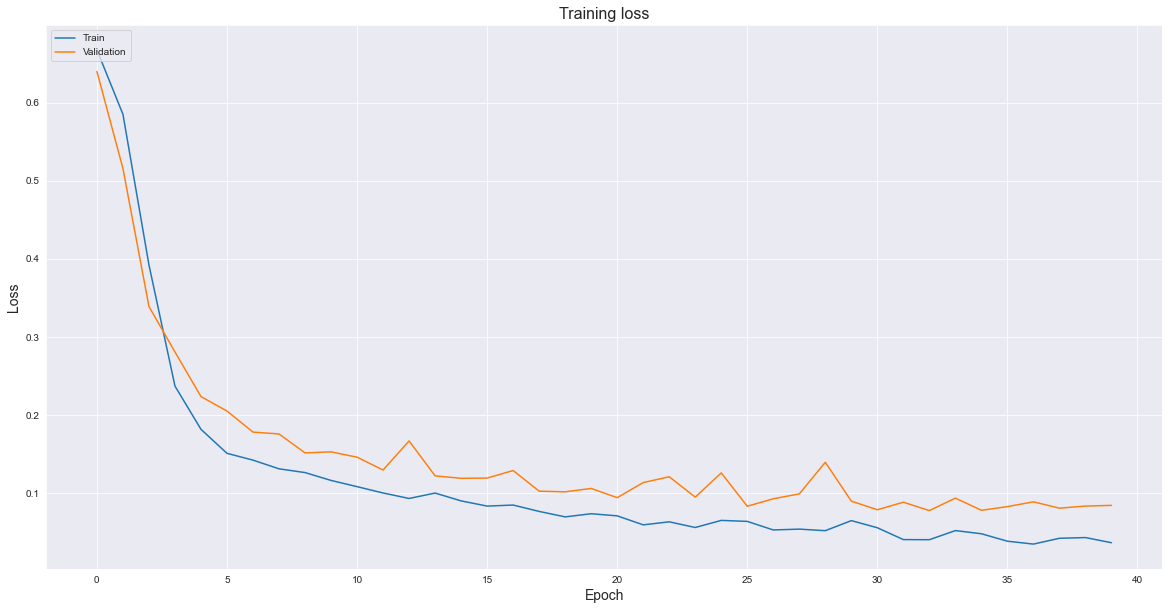

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9948217636022514
validation dataset AUPRC: 0.9938135562840802
validation dataset acc: 0.9775
validation dataset F1: 0.9779951100244498
------Fold 4------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

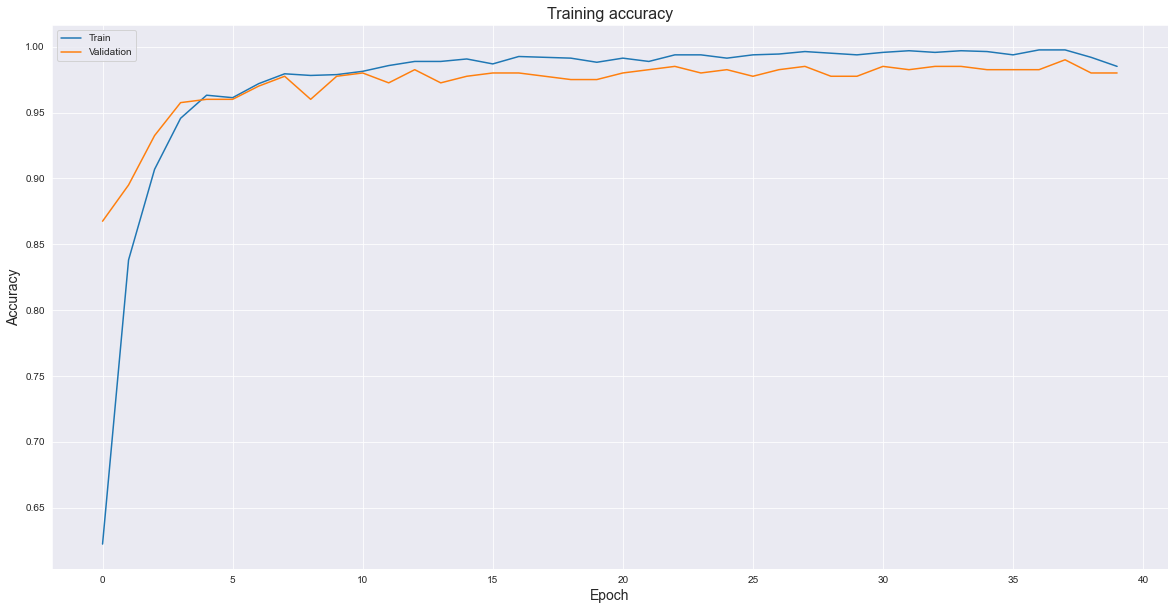

<Figure size 432x288 with 0 Axes>

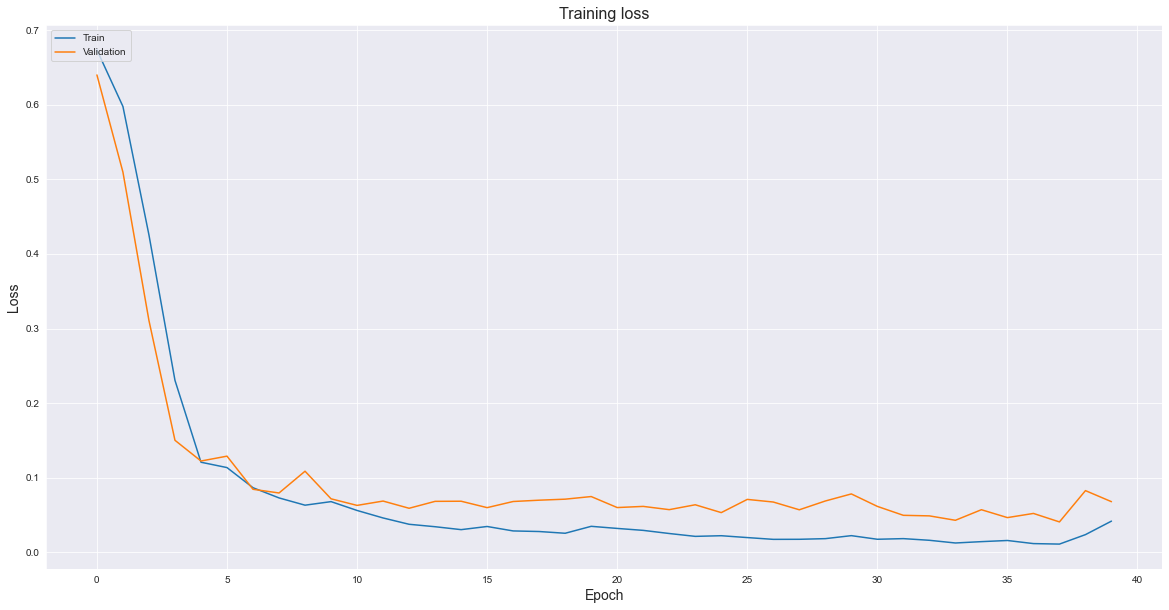

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9974484052532833
validation dataset AUPRC: 0.9971459693012704
validation dataset acc: 0.98
validation dataset F1: 0.9797979797979798
------Fold 5------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

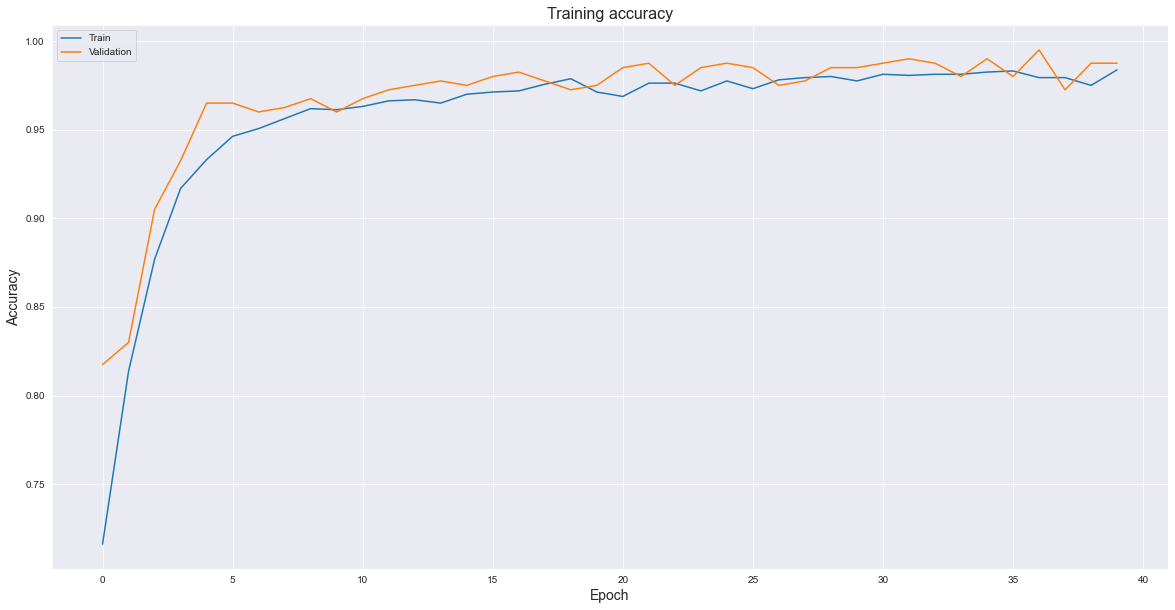

<Figure size 432x288 with 0 Axes>

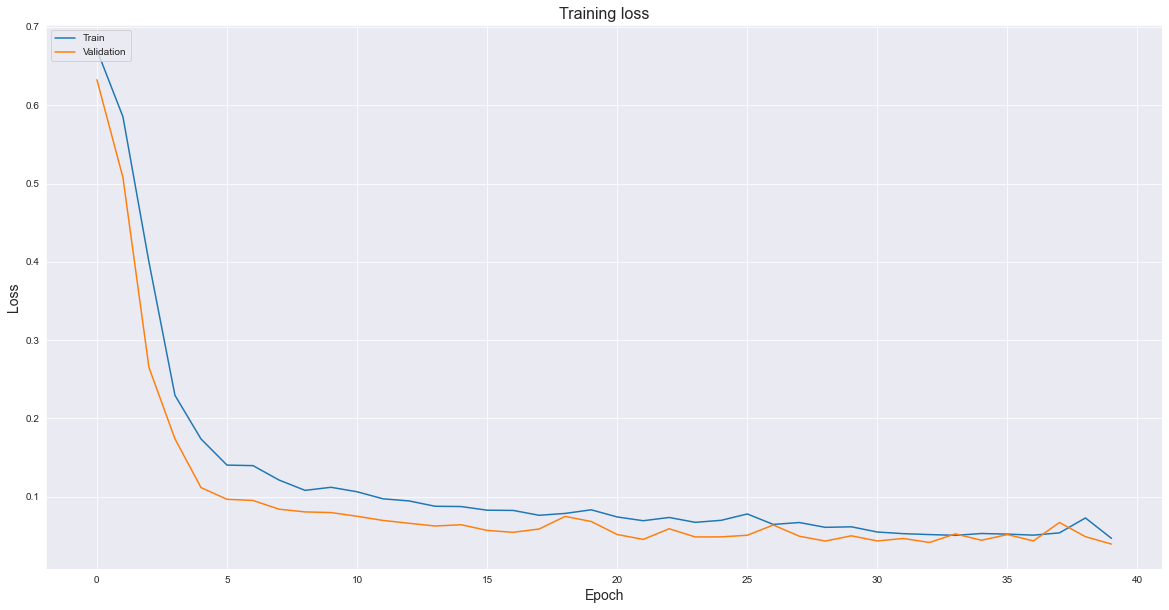

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9980200501253134
validation dataset AUPRC: 0.9978885223879868
validation dataset acc: 0.9875
validation dataset F1: 0.98812351543943
Averaged validation results:
 F1_score:0.9829498786337962
 Accuracy:0.983
 AUROC:0.9969084786806374
 AUPRC:0.9961441926340806



<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [69]:
# load training data
X_feature_engineered_fs = ['HR', 'SaO2', 'Temp', 'SBP', 'MAP', 
                        'DBP', 'RR', 'HCO3', 'PH', 'BUN', 
                        'Calcium', 'Chloride', 'Glucose','Potassium', 'PTT', 
                        'WBC', 'Platelet', 'age', 'HR_dev_2', 'Fever']
y_feature = ['sepsis']
X_train_, y_train_ = process_data_engineered(all_artificial_neonates,artificial_neonatal_data_path, X_feature_engineered_fs)

# lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 5-fold cross validation for tarining model
f1_list = []
accuracy_list = []
auprc_list = []
auroc_list = []
kf =KFold(n_splits=5, shuffle=True, random_state=1221)
for k, (train_index, val_index) in enumerate(kf.split(X_train_, y_train_)):
    test_preds = []
    base_model = clone_model(base_model_f3)
    base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
    print('------Fold {}------'.format(k+1))
    X_train = X_train_[train_index]
    y_train = y_train_[train_index]

    X_val = X_train_[val_index]
    y_val = y_train_[val_index]

    history = base_model.fit(X_train, y_train, epochs=40, batch_size=64, verbose=1, validation_data=(X_val, y_val), shuffle=True)
    base_model.save('./trained_models/frozen3/model_{}.h5'.format(k+1))

    # training accuracy and loss
        # acc
    plt.figure(figsize=(20,10))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training accuracy', size=16)
    plt.ylabel('Accuracy', size=14)
    plt.xlabel('Epoch', size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/frozen3/training_acc_{}.pdf'.format(k+1))
    plt.show()
    plt.clf()
        # loss 
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training loss',size=16)
    plt.ylabel('Loss',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/frozen3/training_loss_{}.pdf'.format(k+1))
    plt.show()
    plt.clf()

    # validation results
    print(' Predicting on validation data...')
    test_preds.append(base_model.predict(X_val,verbose=0).squeeze().reshape(-1, 1).squeeze())
    val_pred_proba = base_model.predict(X_val, verbose=0).squeeze()
    val_pred_class = [0 if i <= 0.5 else 1 for i in val_pred_proba]

    valid_auc = roc_auc_score(y_val, val_pred_proba)
    print('validation dataset AUROC: ' + str(valid_auc))
    precision_, recall_, thresholds_ = precision_recall_curve(y_val, val_pred_proba)
    valid_auprc = auc(recall_, precision_)
    print('validation dataset AUPRC: ' + str(valid_auprc))
    valid_acc = accuracy_score(y_val, val_pred_class)
    print('validation dataset acc: ' + str(valid_acc))
    valid_f1 = f1_score(y_val,val_pred_class)
    print('validation dataset F1: ' + str(valid_f1))
    fpr_, tpr_, thresholds_ = roc_curve(y_val, val_pred_proba)
    accuracy_list.append(valid_acc)
    f1_list.append(valid_f1)
    auroc_list.append(valid_auc)
    auprc_list.append(valid_auprc)

    # 5. plot ROC, PRc and confusion matrix
    bc = BinaryClassification(y_val,val_pred_proba, labels=['Non-sepsis', 'Sepsis'])
    plt.figure(figsize=(20,20))
    plt.subplot2grid(shape=(2,4), loc=(0,0), colspan=2)
    bc.plot_roc_curve()
    plt.subplot2grid((2,4), (0,2), colspan=2)
    bc.plot_precision_recall_curve()
    plt.subplot2grid((2,4), (1,0), colspan=2)
    bc.plot_confusion_matrix()
    plt.subplot2grid((2,4), (1,2), colspan=2)
    bc.plot_confusion_matrix(normalize=True)
    plt.savefig('./figs/frozen3/val_results_{}.pdf'.format(k+1))
    plt.clf()


def Average(lst):
    return sum(lst) / len(lst)

print('Averaged validation results:\n F1_score:{}\n Accuracy:{}\n AUROC:{}\n AUPRC:{}\n'.format(Average(f1_list),Average(accuracy_list), Average(auroc_list), Average(auprc_list)))

Averaged validation results:
* F1_score:0.9829498786337962
* Accuracy:0.983
* AUROC:0.9969084786806374
* AUPRC:0.9961441926340806

### Frozen 2 LSTMs

In [70]:
# case 1: frozen all LSTM
base_model_f2 = tf.keras.models.load_model('../models_adults/model_LSTM/trained_models/EDWFS/model_5.h5')
for i, layer in enumerate(base_model_f2.layers):
    layer._name = 'layer_' + str(i)
base_model_f2.layers[0].trainable = False
base_model_f2.layers[2].trainable = False
base_model_f2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_0 (LSTM)              (None, 40, 128)           76288     
                                                                 
 layer_1 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_2 (LSTM)              (None, 40, 128)           131584    
                                                                 
 layer_3 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_4 (LSTM)              (None, 40, 128)           131584    
                                                                 
 layer_5 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_6 (LSTM)              (None, 128)              

100%|██████████| 2000/2000 [00:13<00:00, 146.41it/s]


------Fold 1------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.7694WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbe46328830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_

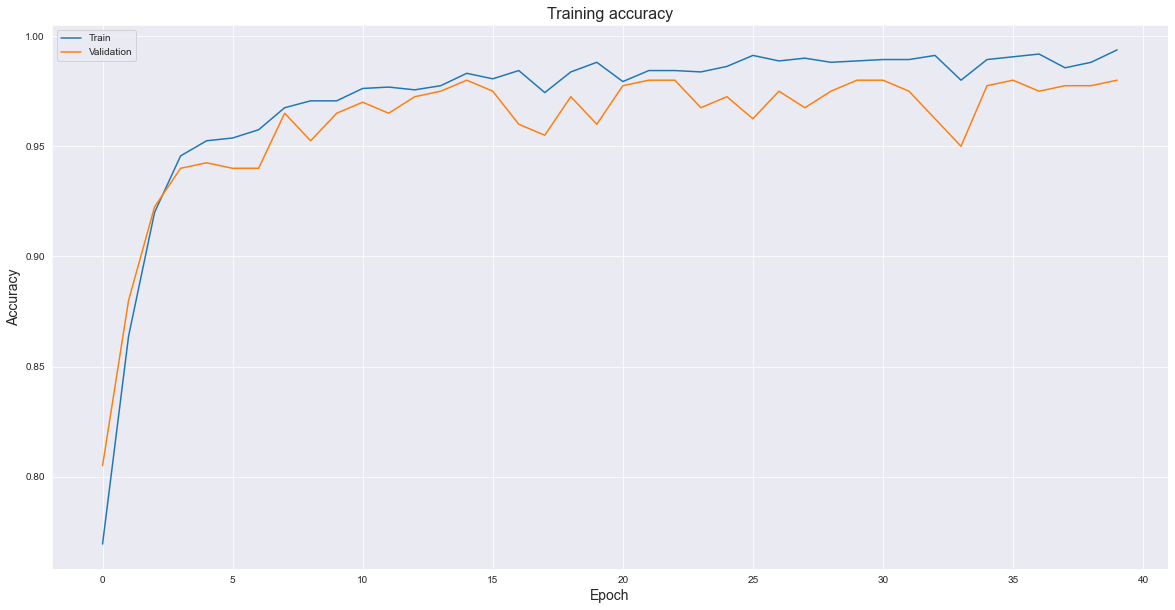

<Figure size 432x288 with 0 Axes>

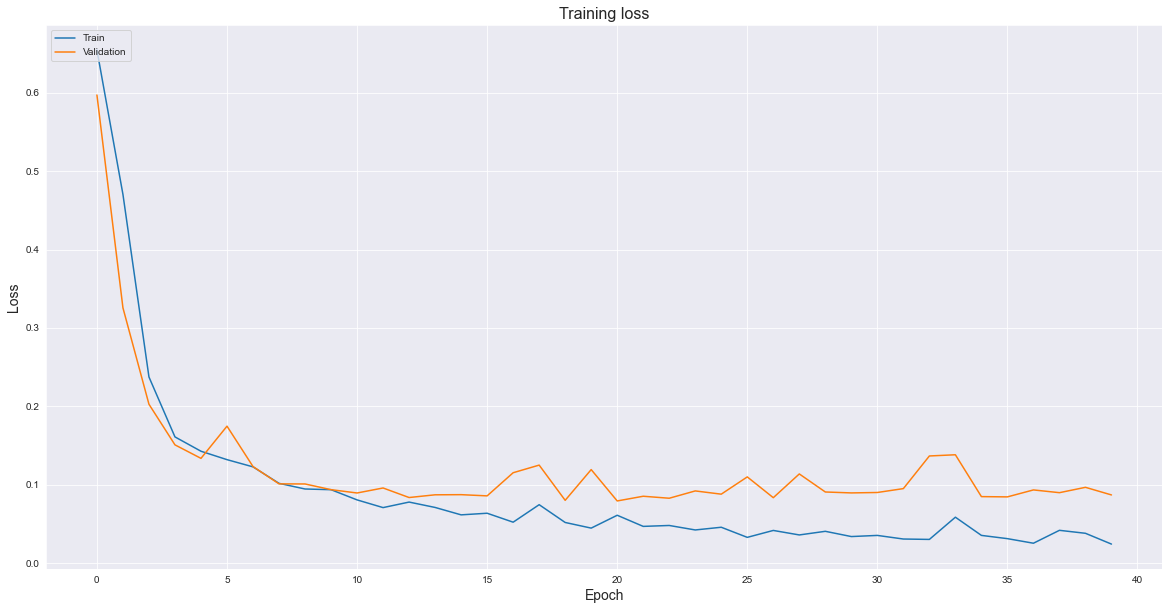

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9953991200502829
validation dataset AUPRC: 0.9942378707356214
validation dataset acc: 0.98
validation dataset F1: 0.978494623655914
------Fold 2------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

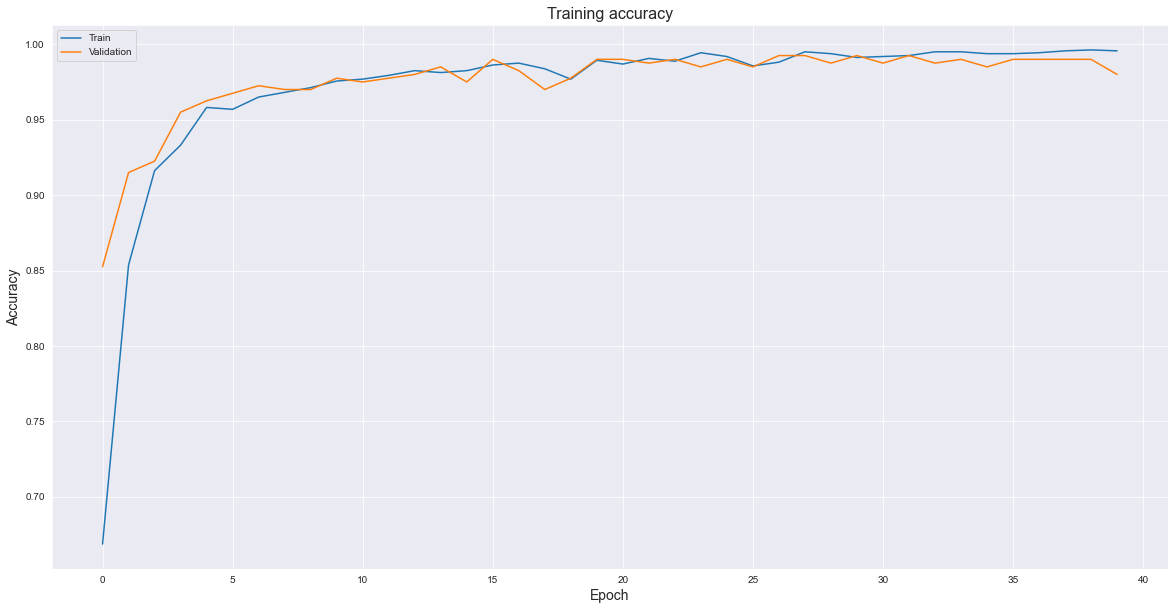

<Figure size 432x288 with 0 Axes>

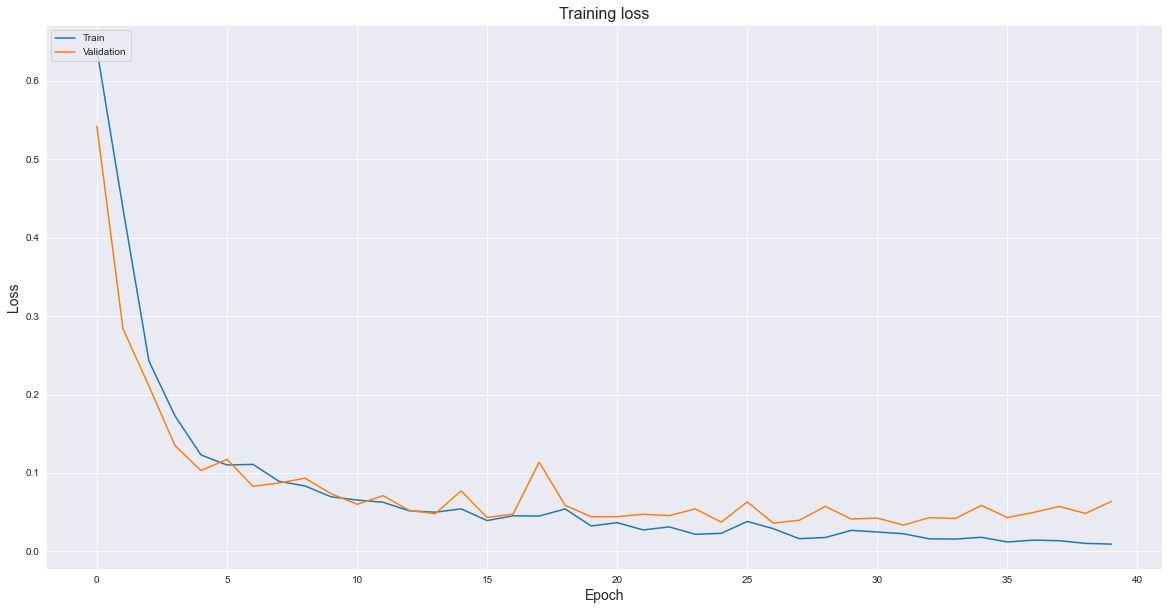

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9970731707317073
validation dataset AUPRC: 0.9968441886545454
validation dataset acc: 0.98
validation dataset F1: 0.9804878048780488
------Fold 3------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

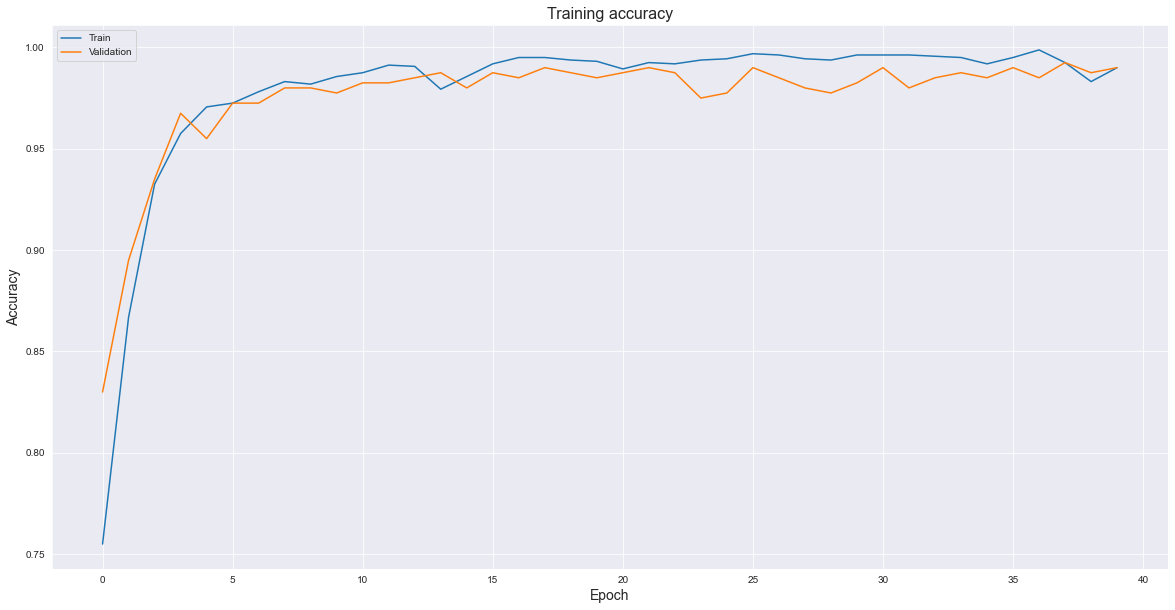

<Figure size 432x288 with 0 Axes>

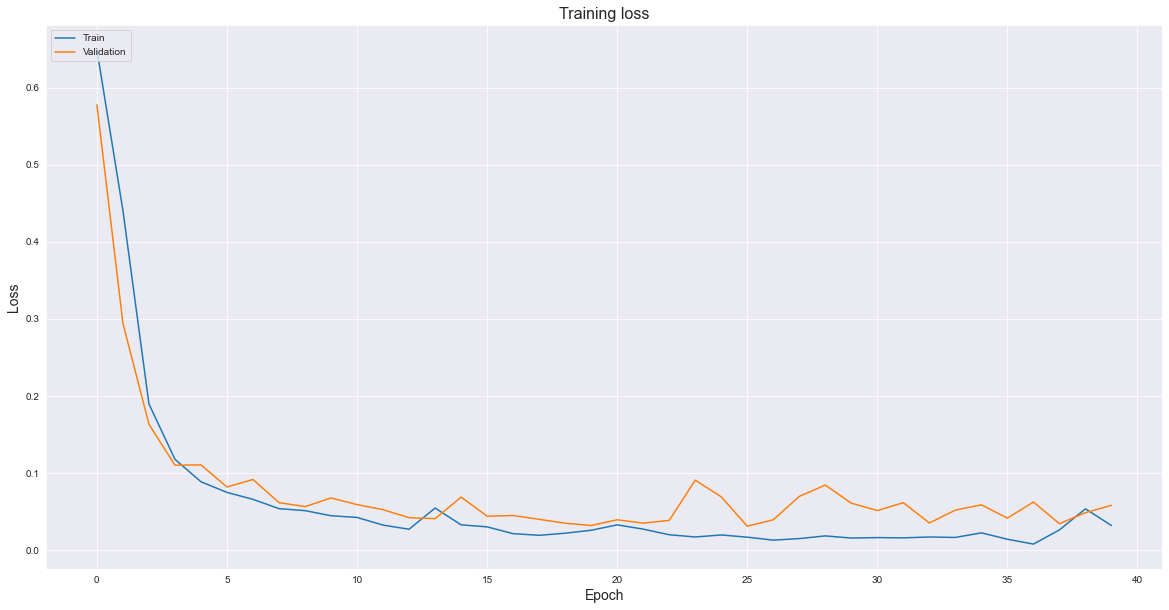

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9987992495309568
validation dataset AUPRC: 0.9988661589631536
validation dataset acc: 0.99
validation dataset F1: 0.9901960784313727
------Fold 4------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

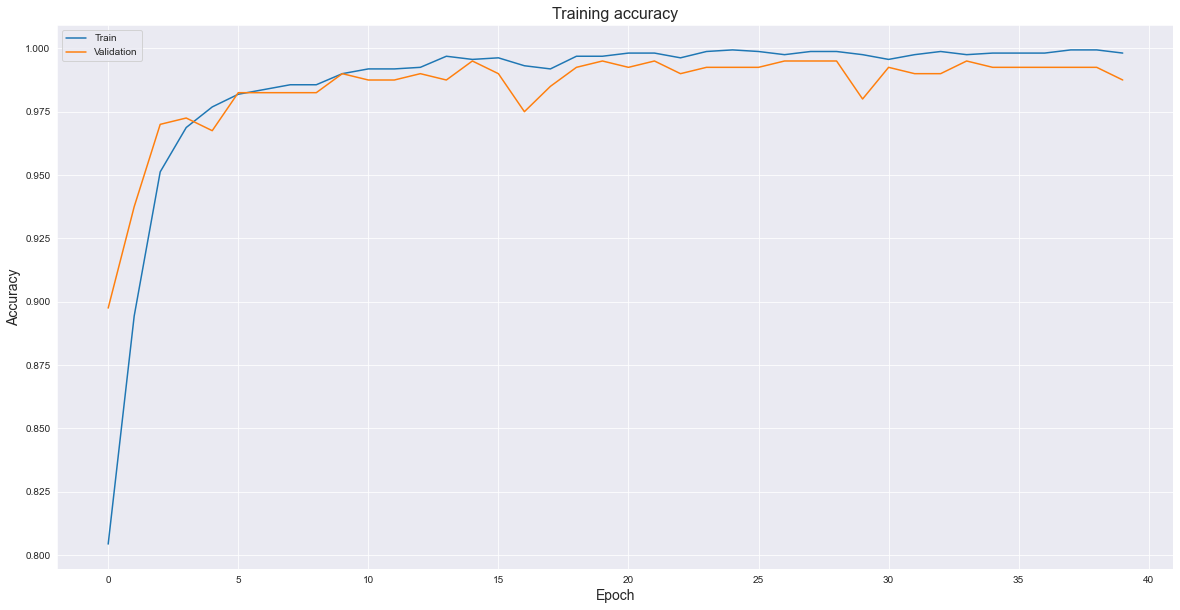

<Figure size 432x288 with 0 Axes>

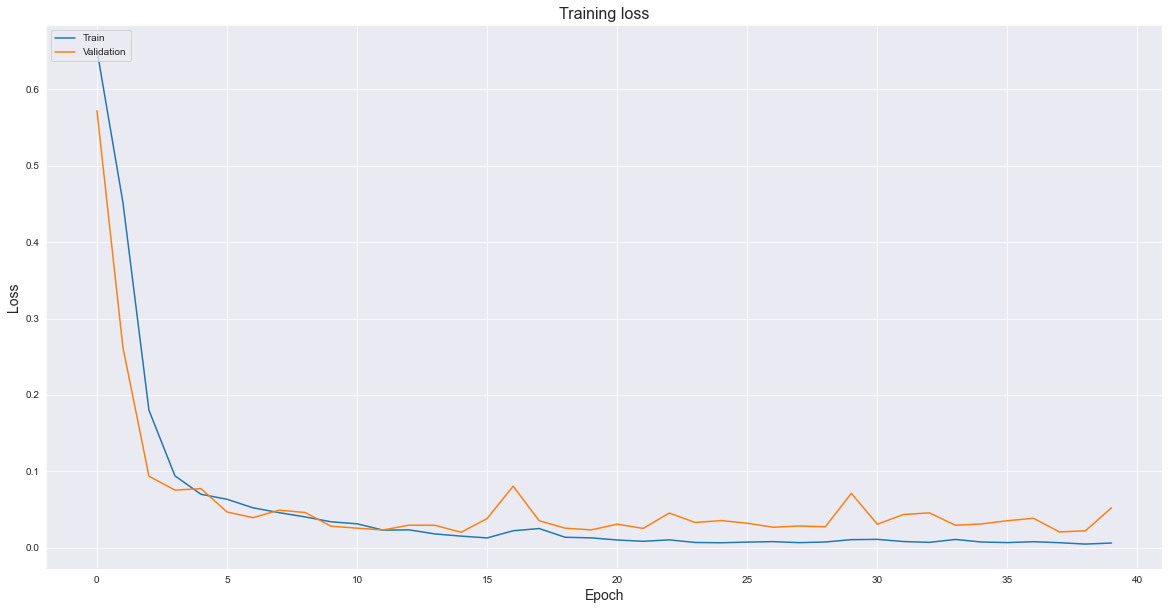

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9987242026266416
validation dataset AUPRC: 0.9985453045427459
validation dataset acc: 0.9875
validation dataset F1: 0.9872773536895675
------Fold 5------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

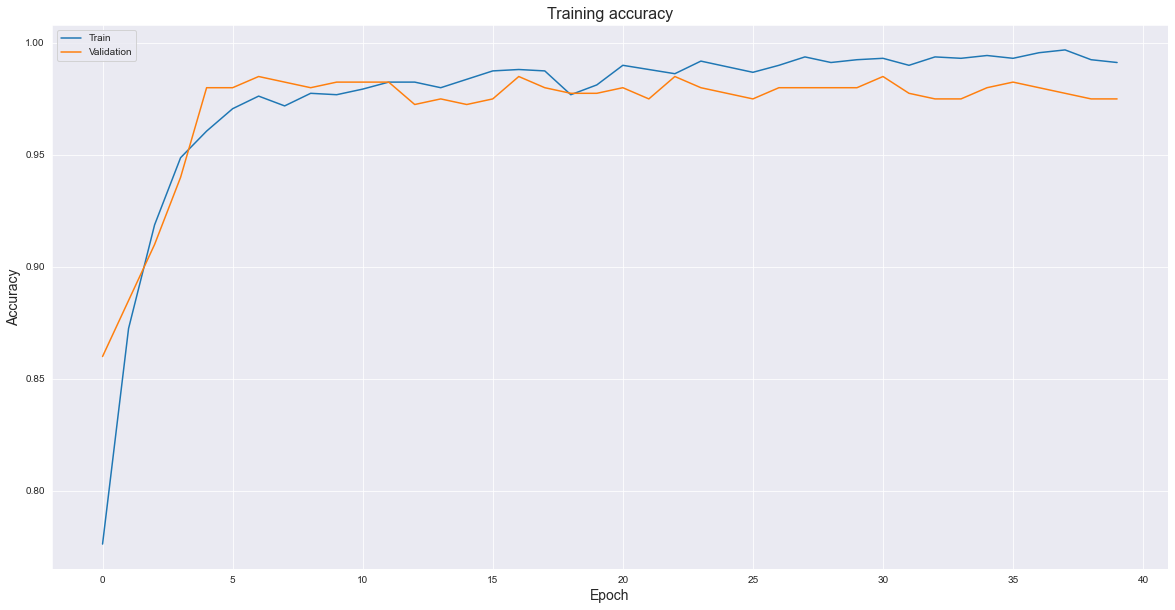

<Figure size 432x288 with 0 Axes>

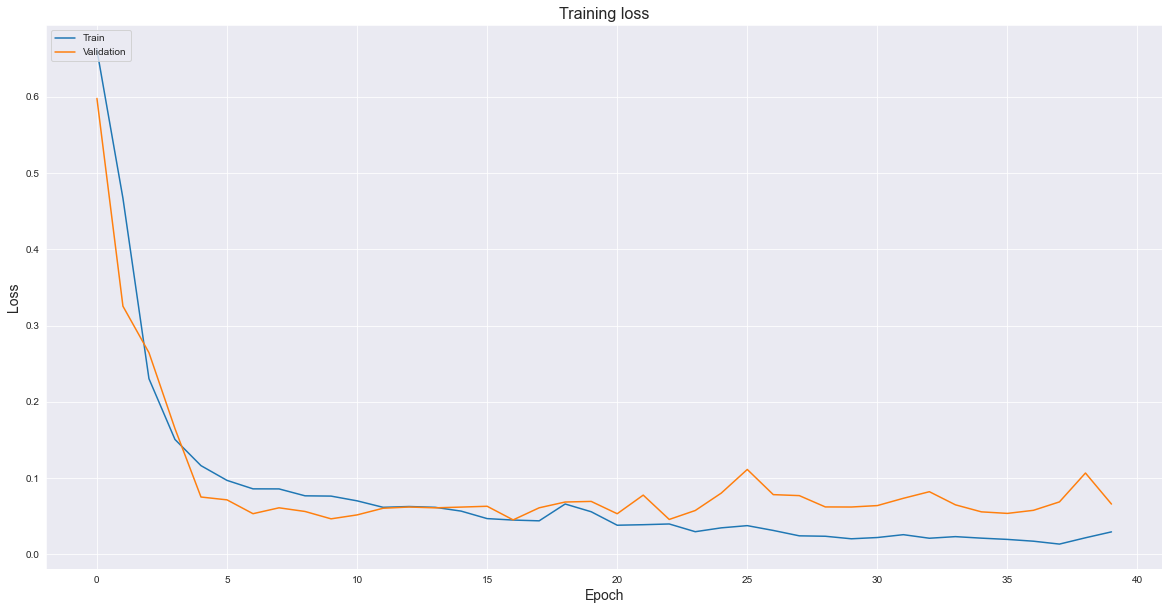

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9977944862155388
validation dataset AUPRC: 0.9979586484871842
validation dataset acc: 0.975
validation dataset F1: 0.9760765550239234
Averaged validation results:
 F1_score:0.9825064831357653
 Accuracy:0.9824999999999999
 AUROC:0.9975580458310255
 AUPRC:0.9972904342766501



<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [71]:
# load training data
X_feature_engineered_fs = ['HR', 'SaO2', 'Temp', 'SBP', 'MAP', 
                        'DBP', 'RR', 'HCO3', 'PH', 'BUN', 
                        'Calcium', 'Chloride', 'Glucose','Potassium', 'PTT', 
                        'WBC', 'Platelet', 'age', 'HR_dev_2', 'Fever']
y_feature = ['sepsis']
X_train_, y_train_ = process_data_engineered(all_artificial_neonates,artificial_neonatal_data_path, X_feature_engineered_fs)

# lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 5-fold cross validation for tarining model
f1_list = []
accuracy_list = []
auprc_list = []
auroc_list = []
kf =KFold(n_splits=5, shuffle=True, random_state=1221)
for k, (train_index, val_index) in enumerate(kf.split(X_train_, y_train_)):
    test_preds = []
    base_model = clone_model(base_model_f2)
    base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
    print('------Fold {}------'.format(k+1))
    X_train = X_train_[train_index]
    y_train = y_train_[train_index]

    X_val = X_train_[val_index]
    y_val = y_train_[val_index]

    history = base_model.fit(X_train, y_train, epochs=40, batch_size=64, verbose=1, validation_data=(X_val, y_val), shuffle=True)
    base_model.save('./trained_models/frozen2/model_{}.h5'.format(k+1))

    # training accuracy and loss
        # acc
    plt.figure(figsize=(20,10))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training accuracy', size=16)
    plt.ylabel('Accuracy', size=14)
    plt.xlabel('Epoch', size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/frozen2/training_acc_{}.pdf'.format(k+1))
    plt.show()
    plt.clf()
        # loss 
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training loss',size=16)
    plt.ylabel('Loss',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/frozen2/training_loss_{}.pdf'.format(k+1))
    plt.show()
    plt.clf()

    # validation results
    print(' Predicting on validation data...')
    test_preds.append(base_model.predict(X_val,verbose=0).squeeze().reshape(-1, 1).squeeze())
    val_pred_proba = base_model.predict(X_val, verbose=0).squeeze()
    val_pred_class = [0 if i <= 0.5 else 1 for i in val_pred_proba]

    valid_auc = roc_auc_score(y_val, val_pred_proba)
    print('validation dataset AUROC: ' + str(valid_auc))
    precision_, recall_, thresholds_ = precision_recall_curve(y_val, val_pred_proba)
    valid_auprc = auc(recall_, precision_)
    print('validation dataset AUPRC: ' + str(valid_auprc))
    valid_acc = accuracy_score(y_val, val_pred_class)
    print('validation dataset acc: ' + str(valid_acc))
    valid_f1 = f1_score(y_val,val_pred_class)
    print('validation dataset F1: ' + str(valid_f1))
    fpr_, tpr_, thresholds_ = roc_curve(y_val, val_pred_proba)
    accuracy_list.append(valid_acc)
    f1_list.append(valid_f1)
    auroc_list.append(valid_auc)
    auprc_list.append(valid_auprc)

    # 5. plot ROC, PRc and confusion matrix
    bc = BinaryClassification(y_val,val_pred_proba, labels=['Non-sepsis', 'Sepsis'])
    plt.figure(figsize=(20,20))
    plt.subplot2grid(shape=(2,4), loc=(0,0), colspan=2)
    bc.plot_roc_curve()
    plt.subplot2grid((2,4), (0,2), colspan=2)
    bc.plot_precision_recall_curve()
    plt.subplot2grid((2,4), (1,0), colspan=2)
    bc.plot_confusion_matrix()
    plt.subplot2grid((2,4), (1,2), colspan=2)
    bc.plot_confusion_matrix(normalize=True)
    plt.savefig('./figs/frozen2/val_results_{}.pdf'.format(k+1))
    plt.clf()


def Average(lst):
    return sum(lst) / len(lst)

print('Averaged validation results:\n F1_score:{}\n Accuracy:{}\n AUROC:{}\n AUPRC:{}\n'.format(Average(f1_list),Average(accuracy_list), Average(auroc_list), Average(auprc_list)))

Averaged validation results:
* F1_score:0.9825064831357653
* Accuracy:0.9824999999999999
* AUROC:0.9975580458310255
* AUPRC:0.9972904342766501

### Frozen 1 LSTMs

In [72]:
# case 1: frozen all LSTM
base_model_f1 = tf.keras.models.load_model('../models_adults/model_LSTM/trained_models/EDWFS/model_5.h5')
for i, layer in enumerate(base_model_f1.layers):
    layer._name = 'layer_' + str(i)
base_model_f1.layers[0].trainable = False
base_model_f1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_0 (LSTM)              (None, 40, 128)           76288     
                                                                 
 layer_1 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_2 (LSTM)              (None, 40, 128)           131584    
                                                                 
 layer_3 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_4 (LSTM)              (None, 40, 128)           131584    
                                                                 
 layer_5 (Dropout)           (None, 40, 128)           0         
                                                                 
 layer_6 (LSTM)              (None, 128)              

100%|██████████| 2000/2000 [00:13<00:00, 148.95it/s]


------Fold 1------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.7175WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbe27b297a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_

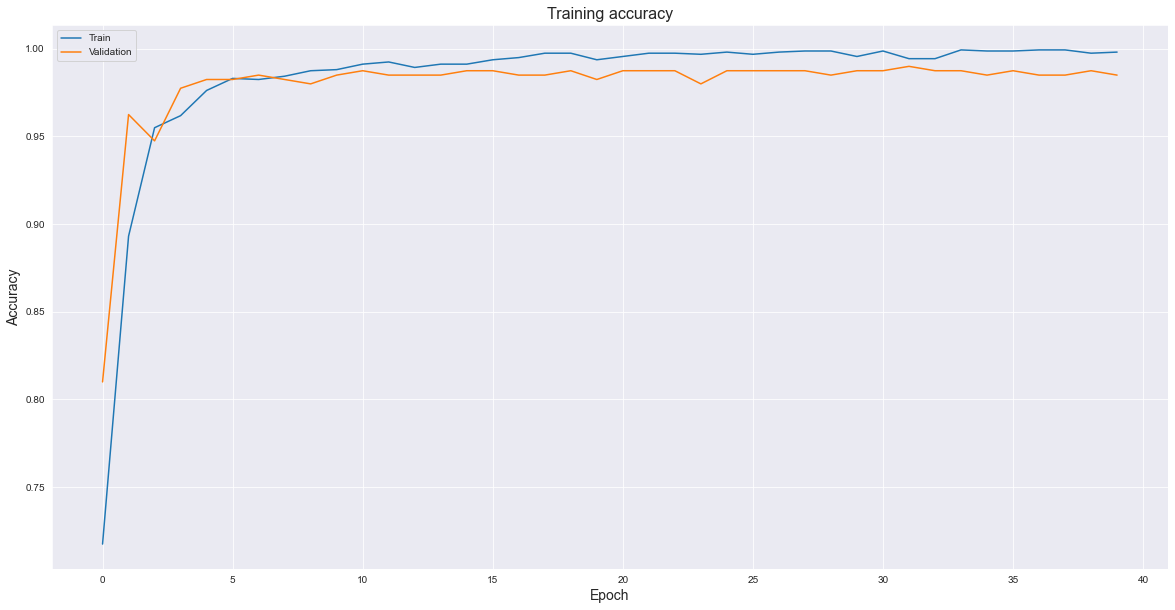

<Figure size 432x288 with 0 Axes>

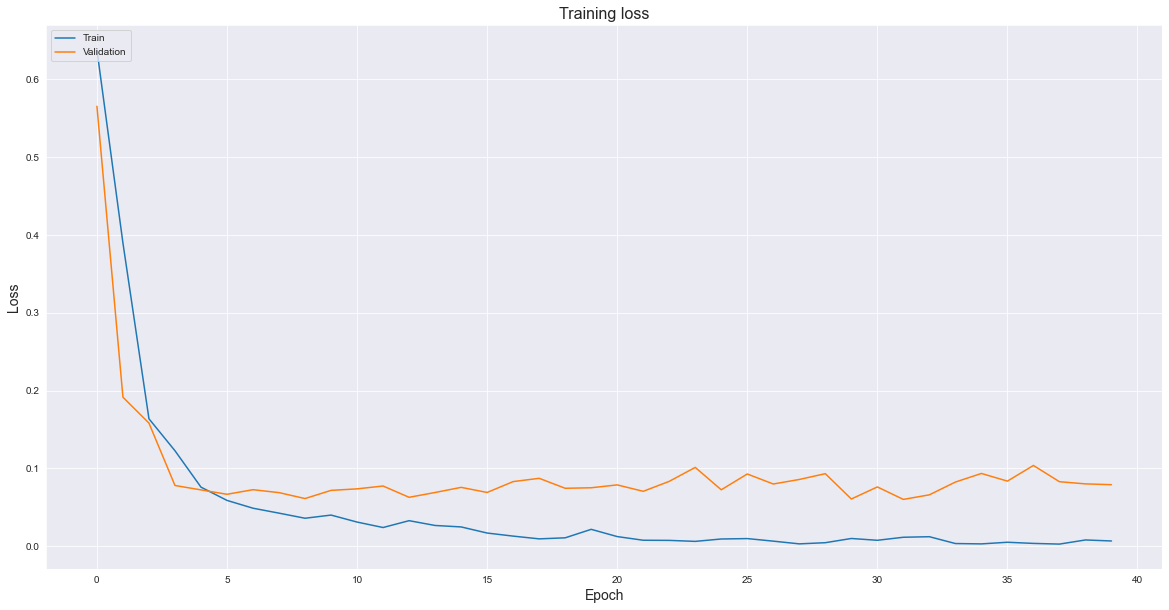

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9991451917033312
validation dataset AUPRC: 0.9991209986838037
validation dataset acc: 0.985
validation dataset F1: 0.9835164835164836
------Fold 2------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

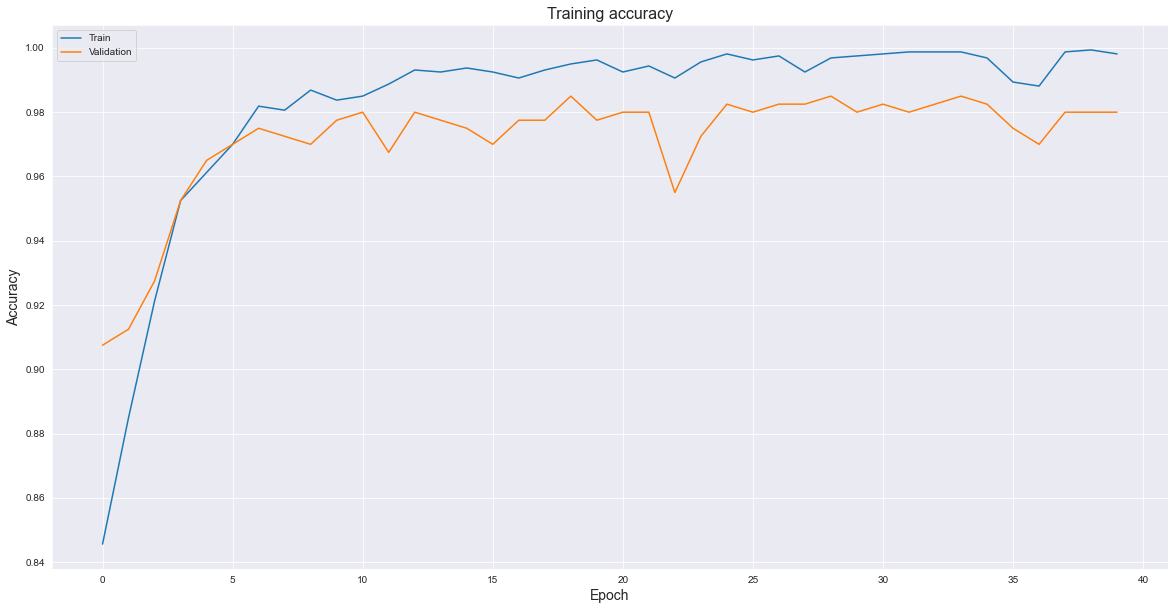

<Figure size 432x288 with 0 Axes>

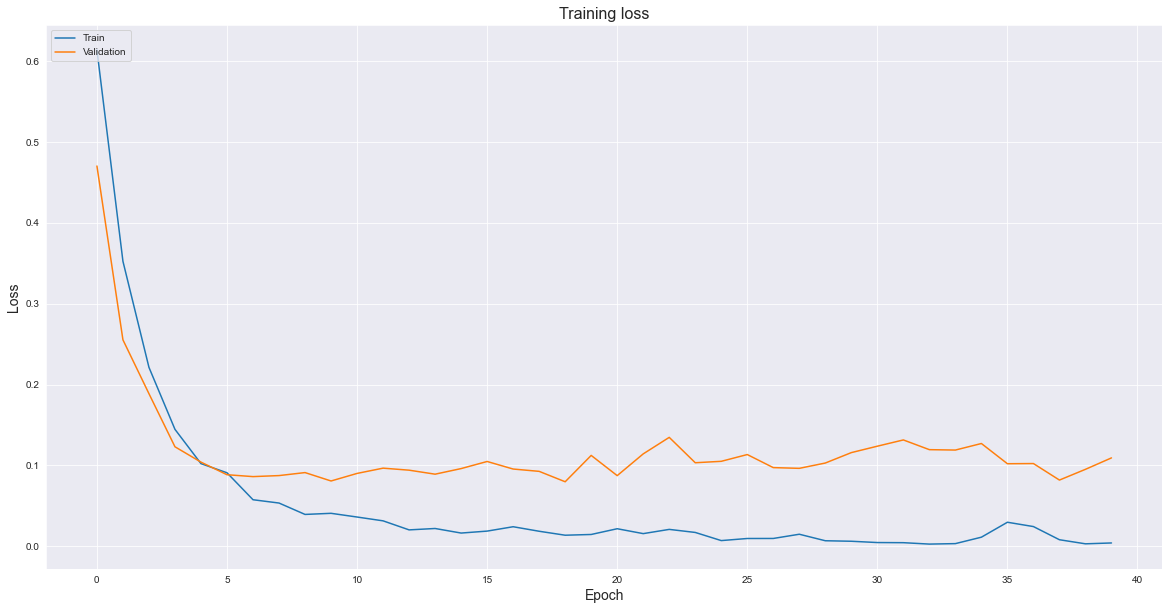

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.995797373358349
validation dataset AUPRC: 0.9954422724898353
validation dataset acc: 0.98
validation dataset F1: 0.9805825242718447
------Fold 3------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

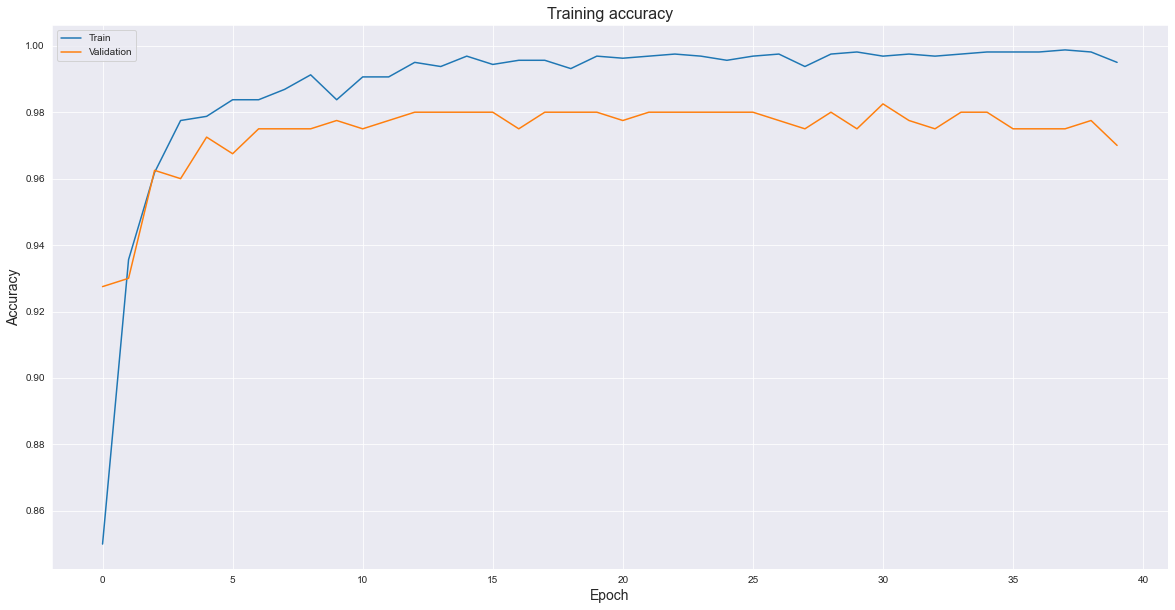

<Figure size 432x288 with 0 Axes>

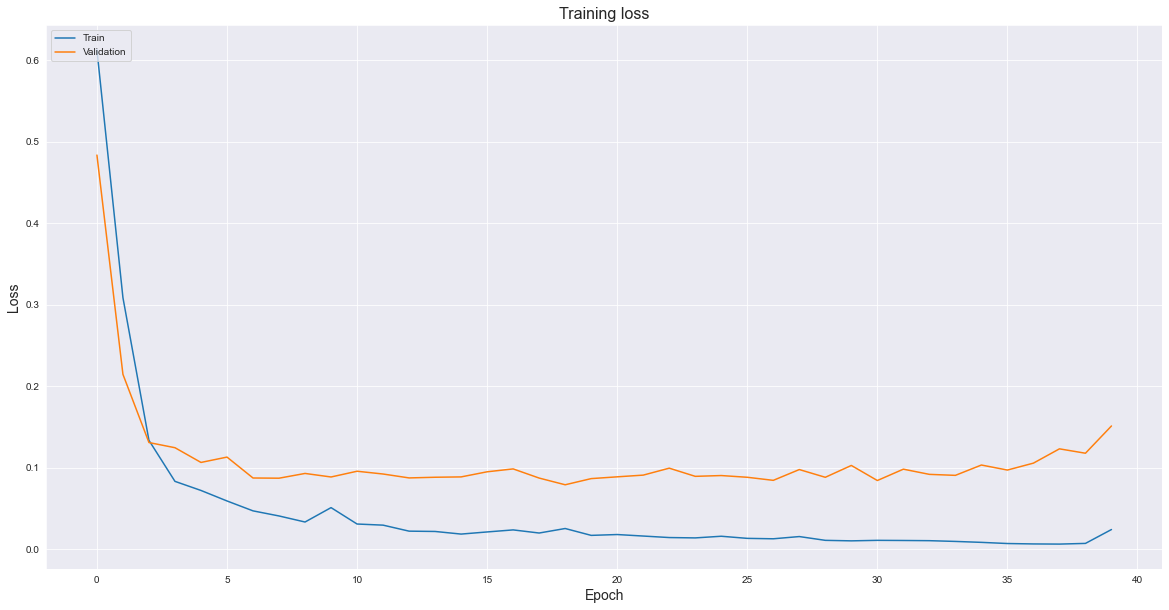

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9858911819887429
validation dataset AUPRC: 0.980454808996728
validation dataset acc: 0.97
validation dataset F1: 0.9712918660287081
------Fold 4------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

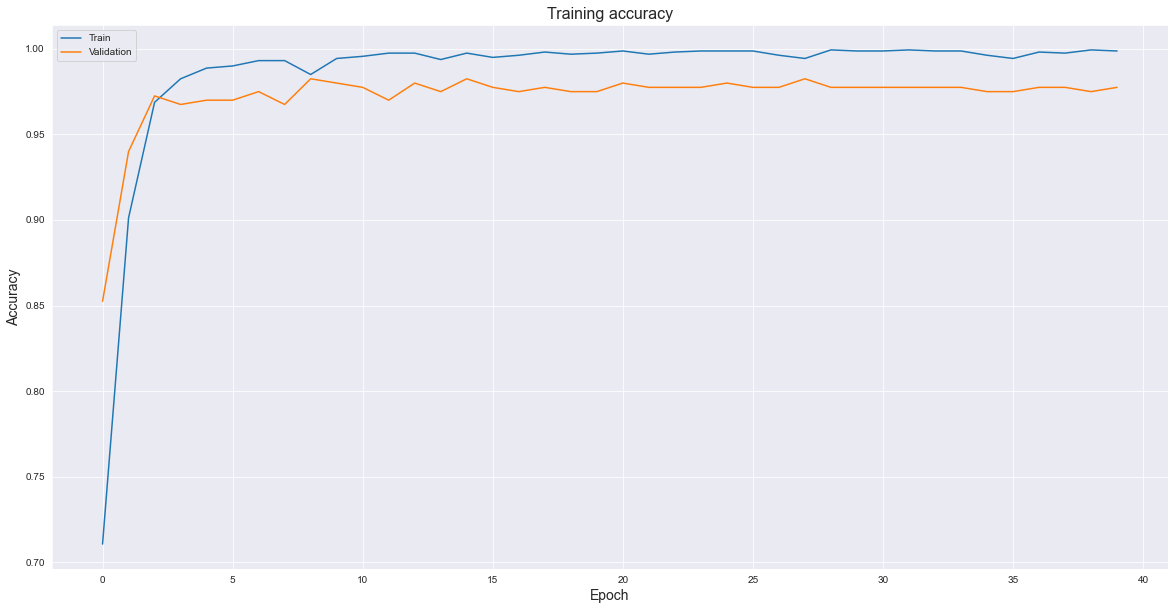

<Figure size 432x288 with 0 Axes>

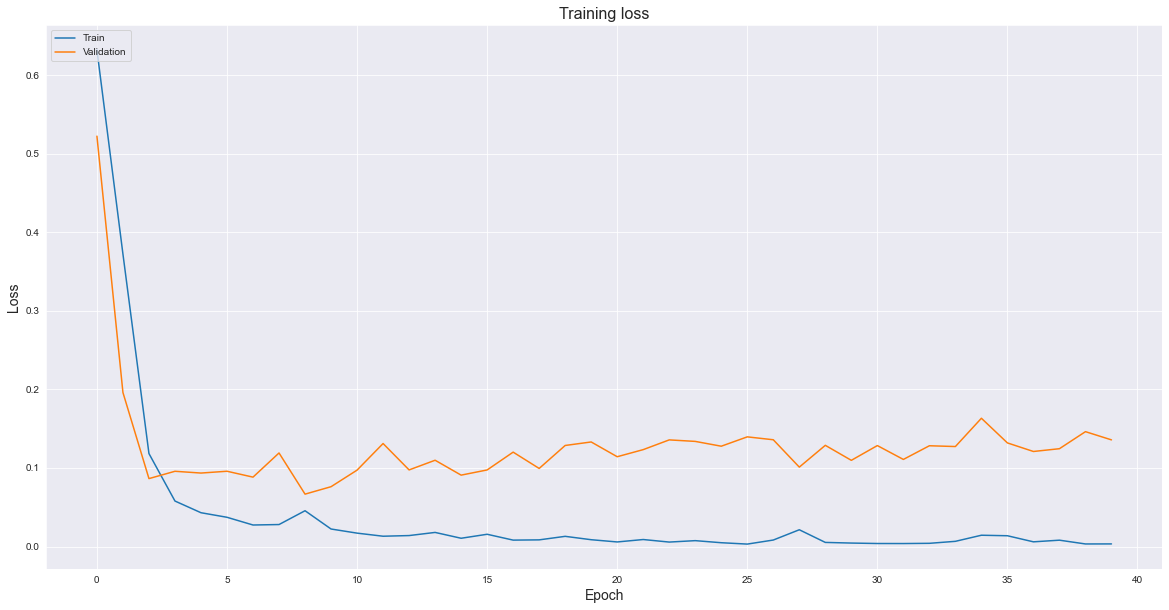

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9942714196372733
validation dataset AUPRC: 0.9921821160300575
validation dataset acc: 0.9775
validation dataset F1: 0.9769820971867007
------Fold 5------
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

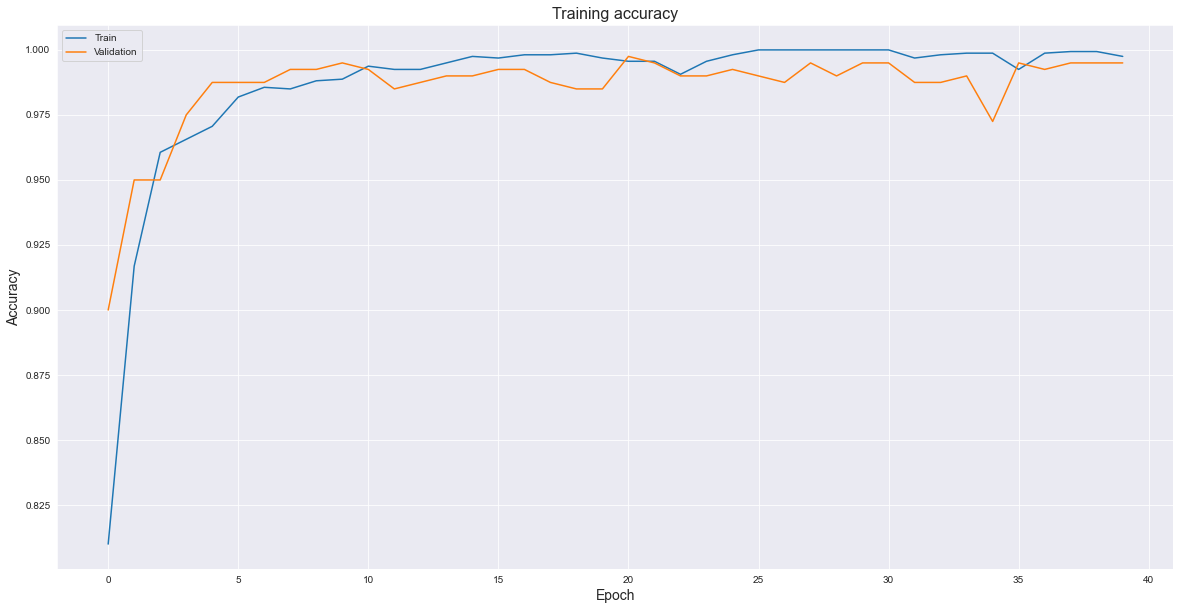

<Figure size 432x288 with 0 Axes>

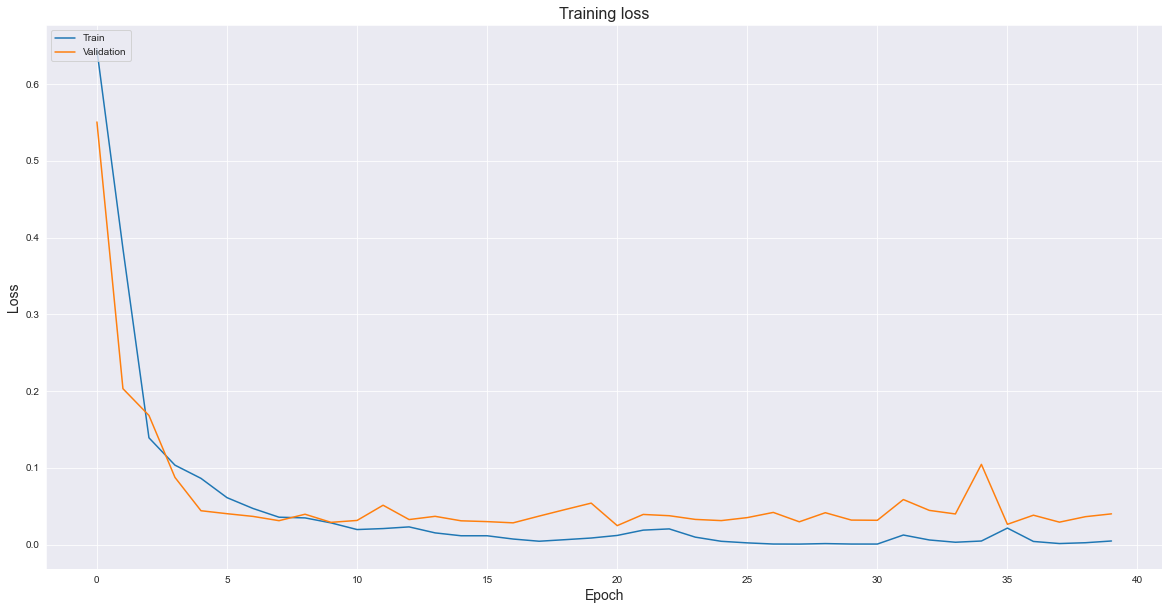

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.9955388471177945
validation dataset AUPRC: 0.9912841781748036
validation dataset acc: 0.995
validation dataset F1: 0.9952606635071091
Averaged validation results:
 F1_score:0.9815267269021692
 Accuracy:0.9814999999999999
 AUROC:0.9941288027610982
 AUPRC:0.9916968748750457



<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [73]:
# load training data
X_feature_engineered_fs = ['HR', 'SaO2', 'Temp', 'SBP', 'MAP', 
                        'DBP', 'RR', 'HCO3', 'PH', 'BUN', 
                        'Calcium', 'Chloride', 'Glucose','Potassium', 'PTT', 
                        'WBC', 'Platelet', 'age', 'HR_dev_2', 'Fever']
y_feature = ['sepsis']
X_train_, y_train_ = process_data_engineered(all_artificial_neonates,artificial_neonatal_data_path, X_feature_engineered_fs)

# lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 5-fold cross validation for tarining model
f1_list = []
accuracy_list = []
auprc_list = []
auroc_list = []
kf =KFold(n_splits=5, shuffle=True, random_state=1221)
for k, (train_index, val_index) in enumerate(kf.split(X_train_, y_train_)):
    test_preds = []
    base_model = clone_model(base_model_f1)
    base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
    print('------Fold {}------'.format(k+1))
    X_train = X_train_[train_index]
    y_train = y_train_[train_index]

    X_val = X_train_[val_index]
    y_val = y_train_[val_index]

    history = base_model.fit(X_train, y_train, epochs=40, batch_size=64, verbose=1, validation_data=(X_val, y_val), shuffle=True)
    base_model.save('./trained_models/frozen1/model_{}.h5'.format(k+1))

    # training accuracy and loss
        # acc
    plt.figure(figsize=(20,10))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training accuracy', size=16)
    plt.ylabel('Accuracy', size=14)
    plt.xlabel('Epoch', size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/frozen1/training_acc_{}.pdf'.format(k+1))
    plt.show()
    plt.clf()
        # loss 
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training loss',size=16)
    plt.ylabel('Loss',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/frozen1/training_loss_{}.pdf'.format(k+1))
    plt.show()
    plt.clf()

    # validation results
    print(' Predicting on validation data...')
    test_preds.append(base_model.predict(X_val,verbose=0).squeeze().reshape(-1, 1).squeeze())
    val_pred_proba = base_model.predict(X_val, verbose=0).squeeze()
    val_pred_class = [0 if i <= 0.5 else 1 for i in val_pred_proba]

    valid_auc = roc_auc_score(y_val, val_pred_proba)
    print('validation dataset AUROC: ' + str(valid_auc))
    precision_, recall_, thresholds_ = precision_recall_curve(y_val, val_pred_proba)
    valid_auprc = auc(recall_, precision_)
    print('validation dataset AUPRC: ' + str(valid_auprc))
    valid_acc = accuracy_score(y_val, val_pred_class)
    print('validation dataset acc: ' + str(valid_acc))
    valid_f1 = f1_score(y_val,val_pred_class)
    print('validation dataset F1: ' + str(valid_f1))
    fpr_, tpr_, thresholds_ = roc_curve(y_val, val_pred_proba)
    accuracy_list.append(valid_acc)
    f1_list.append(valid_f1)
    auroc_list.append(valid_auc)
    auprc_list.append(valid_auprc)

    # 5. plot ROC, PRc and confusion matrix
    bc = BinaryClassification(y_val,val_pred_proba, labels=['Non-sepsis', 'Sepsis'])
    plt.figure(figsize=(20,20))
    plt.subplot2grid(shape=(2,4), loc=(0,0), colspan=2)
    bc.plot_roc_curve()
    plt.subplot2grid((2,4), (0,2), colspan=2)
    bc.plot_precision_recall_curve()
    plt.subplot2grid((2,4), (1,0), colspan=2)
    bc.plot_confusion_matrix()
    plt.subplot2grid((2,4), (1,2), colspan=2)
    bc.plot_confusion_matrix(normalize=True)
    plt.savefig('./figs/frozen1/val_results_{}.pdf'.format(k+1))
    plt.clf()


def Average(lst):
    return sum(lst) / len(lst)

print('Averaged validation results:\n F1_score:{}\n Accuracy:{}\n AUROC:{}\n AUPRC:{}\n'.format(Average(f1_list),Average(accuracy_list), Average(auroc_list), Average(auprc_list)))

Averaged validation results:
* F1_score:0.9815267269021692
* Accuracy:0.9814999999999999
* AUROC:0.9941288027610982
* AUPRC:0.9916968748750457

## Test re-trained model

### Helper Functions

In [74]:
def save_challenge_predictions(file, scores, labels):
    with open(file, 'w') as f:
        f.write('PredictedProbability,PredictedLabel\n')
        for (s, l) in zip(scores, labels):
            f.write('%g,%d\n' % (s, l))

def save_challenge_testlabel(file, labels):
    with open(file, 'w') as f:
        f.write('sepsis\n')
        for l in labels:
            f.write('%d\n' % l)

def load_model_predict(X_test, k_fold, path):
    "ensemble the five LSTM models by averaging their output probabilities"
    test_pred = np.zeros((X_test.shape[0], k_fold))
    for k in range(k_fold):
        # load the model
        model_path_name = path + 'model_{}.h5'.format(k+1)
        loaded_model = load_model(model_path_name)
        # predict
        y_test_pred = loaded_model.predict(X_test)
        y_test_pred = y_test_pred.reshape(len(y_test_pred))
        test_pred[:, k] = y_test_pred # save prediction results 5 times
    test_pred = pd.DataFrame(test_pred)
    result_pro = test_pred.mean(axis=1)

    return result_pro

def feature_extraction(case, data_features):

    labels = np.array(case['sepsis'])
    features = []

    # drop unrelated columns
    case.drop(['subject_id'], axis = 1,inplace = True)
    case.drop(['sepsis'],axis = 1,inplace = True)
    if 'time' in case.columns: 
        case.drop(['time'], axis = 1,inplace = True)

    # features here should be a list of df
    for i in range(len(case)):
        df_slice = case.loc[:i]

        # ------> when test baseline data !!!
        # empty_row = {'HR':0, 'SaO2':0, 'Temp':0, 'SBP':0, 'MAP':0, 'DBP':0, 'RR':0, 'BaseExcess':0, 'HCO3':0,
        #             'PH':0, 'BUN':0, 'Calcium':0, 'Chloride':0, 'Creatinine':0, 'Glucose':0, 'Lactic':0,
        #             'Magnesium':0, 'Potassium':0, 'PTT':0, 'WBC':0, 'Platelet':0, 'age':case['age'][0], 'gender':case['gender'][0]}
        
        # ------> when test engineered data !!!
        df_slice = df_slice.replace([True, False],[1,0])
        empty_row = {'HR':0, 'SaO2':0, 'Temp':0, 'SBP':0, 'MAP':0, 'DBP':0, 'RR':0, 'BaseExcess':0, 'HCO3':0,
                    'PH':0, 'BUN':0, 'Calcium':0, 'Chloride':0, 'Creatinine':0, 'Glucose':0, 'Lactic':0,
                    'Magnesium':0, 'Potassium':0, 'PTT':0, 'WBC':0, 'Platelet':0, 'age':case['age'][0], 'gender':case['gender'][0],
                    'HR_dev_1':0, 'HR_dev_2':0, 'HR_dev_3':0, 'RR_dev_1':0, 'RR_dev_2':0, 'RR_dev_3':0, 'Temp_dev_1':0, 'Temp_dev_2':0, 'Temp_dev_3':0,
                    'Bradycardia':0, 'Tachycardia':0, 'Hypothermia':0, 'Fever':0, 'Hyperpyrexia':0}
                    
        # unify the length of the input df_slice
        if len(df_slice) < 40:
            Pad = pd.DataFrame(empty_row, index =[item for item in range(0,40-len(df_slice))])
            df_slice = pd.concat([Pad, df_slice]).reset_index(drop = True)
        elif len(df_slice) > 40:
            df_slice = df_slice[len(df_slice)-40::1]
        df_slice = df_slice.reset_index(drop = True)

        df_slice = df_slice[data_features] # re-arrange the order of features before converting to array
        # ------> baseline: from df_sliceFrame to numpy array
        # df_slice = df_slice.values 

        # ------> engineered: from DataFrame to numpy array
        df_slice = df_slice.values.astype(np.float64) 
        features.append(df_slice)

    features = np.array(features)

    return  features, labels    

def predict(data_set,
            data_dir,
            save_prediction_dir,
            save_label_dir,
            model_path,
            risk_threshold,
            data_features
            ):
    for csv in tqdm(data_set):
        csv = csv.replace('psv','csv')
        patient = pd.read_csv(data_dir+csv, sep=',')
        features, labels = feature_extraction(patient, data_features)

        predict_pro = load_model_predict(features, k_fold = 5, path = model_path)
        PredictedProbability = np.array(predict_pro)
        PredictedLabel = [0 if i <= risk_threshold else 1 for i in predict_pro]

        save_prediction_name = save_prediction_dir + csv
        save_challenge_predictions(save_prediction_name, PredictedProbability, PredictedLabel)
        save_testlabel_name = save_label_dir + csv
        save_challenge_testlabel(save_testlabel_name, labels)

### Score Functions

In [75]:
# This file contains functions for evaluating algorithms for the 2019 PhysioNet/
# CinC Challenge. You can run it as follows:

################################################################################

# The evaluate_scores function computes a normalized utility score for a cohort
# of patients along with several traditional scoring metrics.
#
# Inputs:
#   'label_directory' is a directory of pipe-delimited text files containing a
#   binary vector of labels for whether a patient is not septic (0) or septic
#   (1) for each time interval.
#
#   'prediction_directory' is a directory of pipe-delimited text files, where
#   the first column of the file gives the predicted probability that the
#   patient is septic at each time, and the second column of the file is a
#   binarized version of this vector. Note that there must be a prediction for
#   every label.
#
# Outputs:
#   'auroc' is the area under the receiver operating characteristic curve
#   (AUROC).
#
#   'auprc' is the area under the precision recall curve (AUPRC).
#
#   'accuracy' is accuracy.
#
#   'f_measure' is F-measure.
#
#   'normalized_observed_utility' is a normalized utility-based measure that we
#   created for the Challenge. This score is normalized so that a perfect score
#   is 1 and no positive predictions is 0.
#
# Example:
#   Omitted due to length. See the below examples.

import numpy as np, os, os.path, sys, warnings

def evaluate_sepsis_score(label_directory, prediction_directory):
    # Set parameters.
    label_header       = 'sepsis'
    prediction_header  = 'PredictedLabel'
    probability_header = 'PredictedProbability'

    dt_early   = -12
    dt_optimal = -6
    dt_late    = 3

    max_u_tp = 1
    min_u_fn = -2
    u_fp     = -0.05
    u_tn     = 0

    # Find label and prediction files.
    label_files = []
    for f in os.listdir(label_directory):
        g = os.path.join(label_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('csv'):
            label_files.append(g)
    label_files = sorted(label_files)

    prediction_files = []
    for f in os.listdir(prediction_directory):
        g = os.path.join(prediction_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('csv'):
            prediction_files.append(g)
    prediction_files = sorted(prediction_files)

    if len(label_files) != len(prediction_files):
        raise Exception('Numbers of label and prediction files must be the same.')

    # Load labels and predictions.
    num_files            = len(label_files)
    cohort_labels        = []
    cohort_predictions   = []
    cohort_probabilities = []

    for k in range(num_files):
        labels        = load_column(label_files[k], label_header, ',')
        predictions   = load_column(prediction_files[k], prediction_header, ',')
        probabilities = load_column(prediction_files[k], probability_header, ',')

        # Check labels and predictions for errors.
        if not (len(labels) == len(predictions) and len(predictions) == len(probabilities)):
            raise Exception('Numbers of labels and predictions for a file must be the same.')

        num_rows = len(labels)

        for i in range(num_rows):
            if labels[i] not in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

            if predictions[i] not in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

            if not 0 <= probabilities[i] <= 1:
                warnings.warn('Probabilities do not satisfy 0 <= probability <= 1.')

        if 0 < np.sum(predictions) < num_rows:
            min_probability_positive = np.min(probabilities[predictions == 1])
            max_probability_negative = np.max(probabilities[predictions == 0])

            if min_probability_positive <= max_probability_negative:
                warnings.warn('Predictions are inconsistent with probabilities, i.e., a positive prediction has a lower (or equal) probability than a negative prediction.')

        # Record labels and predictions.
        cohort_labels.append(labels)
        cohort_predictions.append(predictions)
        cohort_probabilities.append(probabilities)

    # Compute AUC, accuracy, and F-measure.
    labels        = np.concatenate(cohort_labels)
    predictions   = np.concatenate(cohort_predictions)
    probabilities = np.concatenate(cohort_probabilities)

    auroc, auprc        = compute_auc(labels, probabilities)
    accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)

    # Compute utility.
    observed_utilities = np.zeros(num_files)
    best_utilities     = np.zeros(num_files)
    worst_utilities    = np.zeros(num_files)
    inaction_utilities = np.zeros(num_files)

    for k in range(num_files):
        labels = cohort_labels[k]
        num_rows          = len(labels)
        observed_predictions = cohort_predictions[k]
        best_predictions     = np.zeros(num_rows)
        worst_predictions    = np.zeros(num_rows)
        inaction_predictions = np.zeros(num_rows)

        if np.any(labels):
            t_sepsis = np.argmax(labels) - dt_optimal
            best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, num_rows)] = 1
        worst_predictions = 1 - best_predictions

        observed_utilities[k] = compute_prediction_utility(labels, observed_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        best_utilities[k]     = compute_prediction_utility(labels, best_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        worst_utilities[k]    = compute_prediction_utility(labels, worst_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        inaction_utilities[k] = compute_prediction_utility(labels, inaction_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)

    unnormalized_observed_utility = np.sum(observed_utilities)
    unnormalized__utility     = np.sum(best_utilities)
    unnormalized_worst_utility    = np.sum(worst_utilities)
    unnormalized_inaction_utility = np.sum(inaction_utilities)

    normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized__utility - unnormalized_inaction_utility)

    return auroc, auprc, accuracy, f_measure, normalized_observed_utility

# The load_column function loads a column from a table.
#
# Inputs:
#   'filename' is a string containing a filename.
#
#   'header' is a string containing a header.
#
# Outputs:
#   'column' is a vector containing a column from the file with the given
#   header.
#
# Example:
#   Omitted.

def load_column(filename, header, delimiter):
    column = []
    with open(filename, 'r') as f:
        for i, l in enumerate(f):
            arrs = l.strip().split(delimiter)
            if i == 0:
                try:
                    j = arrs.index(header)
                except:
                    raise Exception('{} must contain column with header {} containing numerical entries.'.format(filename, header))
            else:
                if len(arrs[j]):
                    column.append(float(arrs[j]))
    return np.array(column)

# The compute_auc function computes AUROC and AUPRC as well as other summary
# statistics (TP, FP, FN, TN, tpr_, TNR, PPV, NPV, etc.) that can be exposed
# from this function.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a probability vector, where predictions[i] gives the
#   predicted probability that the patient is septic at time i.  Note that there
#   must be a prediction for every label, i.e, len(labels) ==
#   len(predictions).
#
# Outputs:
#   'auroc' is a scalar that gives the AUROC of the algorithm using its
#   predicted probabilities, where specificity is interpolated for intermediate
#   sensitivity values.
#
#   'auprc' is a scalar that gives the AUPRC of the algorithm using its
#   predicted probabilities, where precision is a piecewise constant function of
#   recall.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0.3, 0.4, 0.6, 0.7, 0.8, 0.8]
#   In [3]: auroc, auprc = compute_auc(labels, predictions)
#   In [4]: auroc
#   Out[4]: 1.0
#   In [5]: auprc
#   Out[5]: 1.0

def compute_auc(labels, predictions, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not 0 <= prediction <= 1:
                warnings.warn('Predictions do not satisfy 0 <= prediction <= 1.')

    # Find prediction thresholds.
    thresholds = np.unique(predictions)[::-1]
    if thresholds[0] != 1:
        thresholds = np.insert(thresholds, 0, 1)
    if thresholds[-1] == 0:
        thresholds = thresholds[:-1]

    n = len(labels)
    m = len(thresholds)

    # Populate contingency table across prediction thresholds.
    tp = np.zeros(m)
    fp = np.zeros(m)
    fn = np.zeros(m)
    tn = np.zeros(m)

    # Find indices that sort the predicted probabilities from largest to
    # smallest.
    idx = np.argsort(predictions)[::-1]

    i = 0
    for j in range(m):
        # Initialize contingency table for j-th prediction threshold.
        if j == 0:
            tp[j] = 0
            fp[j] = 0
            fn[j] = np.sum(labels)
            tn[j] = n - fn[j]
        else:
            tp[j] = tp[j - 1]
            fp[j] = fp[j - 1]
            fn[j] = fn[j - 1]
            tn[j] = tn[j - 1]

        # Update contingency table for i-th largest predicted probability.
        while i < n and predictions[idx[i]] >= thresholds[j]:
            if labels[idx[i]]:
                tp[j] += 1
                fn[j] -= 1
            else:
                fp[j] += 1
                tn[j] -= 1
            i += 1

    # Summarize contingency table.
    tpr_ = np.zeros(m)
    tnr = np.zeros(m)
    ppv = np.zeros(m)
    npv = np.zeros(m)

    for j in range(m):
        if tp[j] + fn[j]:
            tpr_[j] = tp[j] / (tp[j] + fn[j])
        else:
            tpr_[j] = 1
        if fp[j] + tn[j]:
            tnr[j] = tn[j] / (fp[j] + tn[j])
        else:
            tnr[j] = 1
        if tp[j] + fp[j]:
            ppv[j] = tp[j] / (tp[j] + fp[j])
        else:
            ppv[j] = 1
        if fn[j] + tn[j]:
            npv[j] = tn[j] / (fn[j] + tn[j])
        else:
            npv[j] = 1

    # Compute AUROC as the area under a piecewise linear function with tpr_ /
    # sensitivity (x-axis) and TNR / specificity (y-axis) and AUPRC as the area
    # under a piecewise constant with tpr_ / recall (x-axis) and PPV / precision
    # (y-axis).
    auroc = 0
    auprc = 0
    for j in range(m-1):
        auroc += 0.5 * (tpr_[j + 1] - tpr_[j]) * (tnr[j + 1] + tnr[j])
        auprc += (tpr_[j + 1] - tpr_[j]) * ppv[j + 1]

    return auroc, auprc

# The compute_accuracy_f_measure function computes the accuracy and F-measure
# for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'accuracy' is a scalar that gives the accuracy of the predictions using its
#   binarized predictions.
#
#   'f_measure' is a scalar that gives the F-measure of the predictions using its
#   binarized predictions.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0, 0, 1, 1, 1, 1]
#   In [3]: accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)
#   In [4]: accuracy
#   Out[4]: 0.666666666667
#   In [5]: f_measure
#   Out[5]: 0.666666666667

def compute_accuracy_f_measure(labels, predictions, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not prediction in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    # Populate contingency table.
    n = len(labels)
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(n):
        if labels[i] and predictions[i]:
            tp += 1
        elif not labels[i] and predictions[i]:
            fp += 1
        elif labels[i] and not predictions[i]:
            fn += 1
        elif not labels[i] and not predictions[i]:
            tn += 1

    # Summarize contingency table.
    if tp + fp + fn + tn:
        accuracy = float(tp + tn) / float(tp + fp + fn + tn)
    else:
        accuracy = 1.0

    if 2 * tp + fp + fn:
        f_measure = float(2 * tp) / float(2 * tp + fp + fn)
    else:
        f_measure = 1.0

    return accuracy, f_measure

# The compute_prediction_utility function computes the total time-dependent
# utility for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'utility' is a scalar that gives the total time-dependent utility of the
#   algorithm using its binarized predictions.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0, 0, 1, 1, 1, 1]
#   In [3]: utility = compute_prediction_utility(labels, predictions)
#   In [4]: utility
#   Out[4]: 3.388888888888889

def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not prediction in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

        if dt_early >= dt_optimal:
            raise Exception('The earliest beneficial time for predictions must be before the optimal time.')

        if dt_optimal >= dt_late:
            raise Exception('The optimal time for predictions must be before the latest beneficial time.')

    # Does the patient eventually have sepsis?
    if np.any(labels):
        is_septic = True
        t_sepsis = np.argmax(labels) - dt_optimal
    else:
        is_septic = False
        t_sepsis = float('inf')

    n = len(labels)

    # Define slopes and intercept points for utility functions of the form
    # u = m * t + b.
    m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
    b_1 = -m_1 * dt_early
    m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
    b_2 = -m_2 * dt_late
    m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
    b_3 = -m_3 * dt_optimal

    # Compare predicted and true conditions.
    u = np.zeros(n)
    for t in range(n):
        if t <= t_sepsis + dt_late:
            # TP
            if is_septic and predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                elif t <= t_sepsis + dt_late:
                    u[t] = m_2 * (t - t_sepsis) + b_2
            # FP
            elif not is_septic and predictions[t]:
                u[t] = u_fp
            # FN
            elif is_septic and not predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = 0
                elif t <= t_sepsis + dt_late:
                    u[t] = m_3 * (t - t_sepsis) + b_3
            # TN
            elif not is_septic and not predictions[t]:
                u[t] = u_tn

    # Find total utility for patient.
    return np.sum(u)

### Frozen 4

In [76]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../models_neoantes/data/test_set_balanced.npy')
test_data_path = '../datasets/MIMICIII/neonates/engineered_all/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/frozen4/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility

0.6189166954271403|0.07094095405164628|0.052666320901504075|0.07299068007751222|0.27406207154431017

### Frozen 3

In [82]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../models_neoantes/data/test_set_balanced.npy')
test_data_path = '../datasets/MIMICIII/neonates/engineered_all/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/frozen3/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)

AUROC|AUPRC|Accuracy|F-measure|Utility

0.6212115273712405|0.05820532074724263|0.0416332688952803|0.07221106445134197|0.26531222734637916

### Frozen 2

In [87]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../models_neoantes/data/test_set_balanced.npy')
test_data_path = '../datasets/MIMICIII/neonates/engineered_all/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/frozen2/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility

0.5774602216952661|0.04251904142597343|0.04139751992078834|0.07219458768767398|0.2651252648635174

### Frozen 1

In [89]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../models_neoantes/data/test_set_balanced.npy')
test_data_path = '../datasets/MIMICIII/neonates/engineered_all/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/frozen1/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility

0.5708308241445327|0.04445433713178572|0.04186901786977227|0.07222754873761585|0.265499189829241